# 📊 Feature Explanation – IEEE-CIS Fraud Detection

## 1. Transaction Features
- **TransactionID**: Unique identifier for each transaction. Used to merge with the identity table, not directly useful for modeling.  
- **TransactionDT**: Time in seconds from a reference point (not a real timestamp).
- **TransactionAmt**: Transaction amount. Fraud often involves:  
  - Very small amounts (testing stolen cards).  
  - Very large amounts (cash-out quickly).  
- **ProductCD**: Product category (e.g., W, C, H, R, S).  

---

## 2. Card Features (card1–card6)
- **card1**: User/account identifier (anonymized).
- **card2**: Issuing bank (anonymized).  
- **card3**: Country of issuing bank.  
- **card4**: Card type (Visa, MasterCard, Amex, etc.).  
- **card5**: Card series number.  
- **card6**: Card category (credit/debit).    

---

## 3. Address Features
- **addr1**: Billing region.  
- **addr2**: Billing country.  

---

## 4. Email Features
- **P_emaildomain**: Purchaser’s email domain.  
- **R_emaildomain**: Recipient’s email domain.  

---

## 5. Counting Features (C1–C14)
- Pre-engineered **count statistics** (anonymized).  
- Example meaning: number of transactions linked to a card or user.  

---

## 6. Time Delta Features (D1–D15)
- Pre-engineered **time-related deltas**.  
- Examples:  
  - `D1` ≈ days since first transaction of user.  
  - `D10` ≈ days since last billing.  

---

## 7. Matching Features (M1–M9)
- Boolean flags (Yes/No/NaN).  
- Indicate whether information matches across sources (e.g., billing vs. shipping address, email vs. card info).  

---

## 8. Engineered Features (V1–V339)
- Large set of anonymized engineered features.  
- Likely derived from C/D/M variables via normalization, statistical transformations, or PCA.  


---

## 9. Identity Features
- **DeviceType**: Desktop or mobile.  
- **DeviceInfo**: OS/browser/device information.  
- **id_01–id_38**: Digital identity flags (proxy usage, cookies, authentication methods, risk scores).  

---

## ✅ Summary
- **Transaction-related features**: core info (time, amount, product).  
- **Card/Address/Email**: user identifiers, useful for grouping & mismatch detection.  
- **C, D, M features**: pre-computed stats on frequency, time deltas, matches.  
- **V features**: anonymized engineered variables.  
- **Identity features**: digital fingerprint of users.  

Together, these 400+ features provide rich signals for modeling fraud detection.

# Pre-Processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler , LabelEncoder , RobustScaler
from sklearn.impute import SimpleImputer

pd.set_option('display.max_columns', None)

pd.set_option('display.max_rows', None)

In [2]:
df = pd.read_csv('data/train_merged.csv')

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: category(1), float64(393), int64(3), object(37)
memory usage: 1.9+ GB


## IV Value
Information value (IV) is one of the most useful technique to select important variables in a predictive model. It helps to rank variables on the basis of their importance. The IV is calculated using the following formula :


| Information Value | Variable Predictiveness       |
|-------------------|-------------------------------|
| < 0.02            | Not useful for prediction     |
| 0.02 – 0.1        | Weak predictive power         |
| 0.1 – 0.3         | Medium predictive power       |
| 0.3 – 0.5         | Strong predictive power       |
| > 0.5             | Suspicious predictive power   |

In [3]:
def calculate_iv(data: pd.DataFrame, feature: str, target: str):
    crosstab = pd.crosstab(data[feature], data[target], normalize=False)

    if 0 not in crosstab.columns:
        crosstab[0] = 0
    if 1 not in crosstab.columns:
        crosstab[1] = 0

    crosstab = crosstab.rename(columns={0: 'Good', 1: 'Bad'})

    crosstab['Total'] = crosstab['Good'] + crosstab['Bad']
    crosstab['Good%'] = crosstab['Good'] / crosstab['Good'].sum()
    crosstab['Bad%'] = crosstab['Bad'] / crosstab['Bad'].sum()

    crosstab = crosstab[(crosstab['Good%'] > 0) & (crosstab['Bad%'] > 0)]

    crosstab['WOE'] = np.log(crosstab['Good%'] / crosstab['Bad%'])
    crosstab['IV'] = (crosstab['Good%'] - crosstab['Bad%']) * crosstab['WOE']

    return crosstab['IV'].sum()



## Transaction Features

#### Missing value

In [4]:
trans_feature = ['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD']

for col in trans_feature :
  col_type =  df[col].dtype
  missing_values = df[col].isnull().sum()
  print(f'{col} is {col_type} and have {missing_values} missing values')

TransactionID is int64 and have 0 missing values
TransactionDT is int64 and have 0 missing values
TransactionAmt is float64 and have 0 missing values
ProductCD is object and have 0 missing values


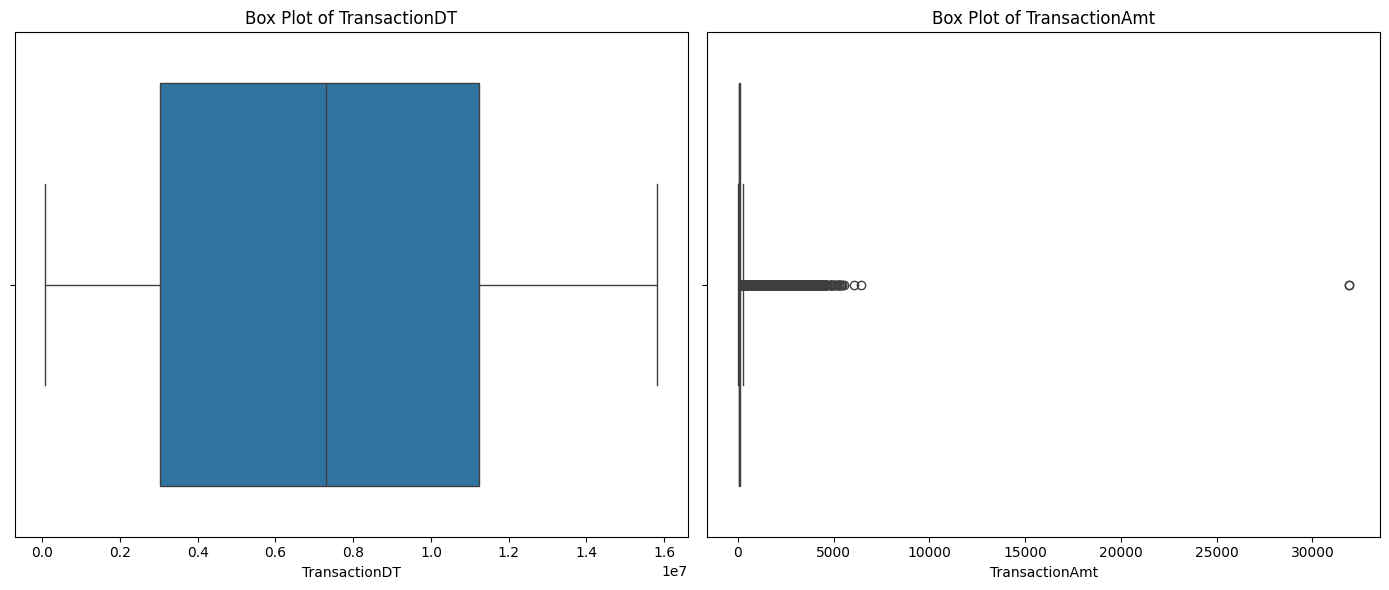

In [5]:

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# TransactionDT
sns.boxplot(x=df['TransactionDT'], ax=axs[0])
axs[0].set_title('Box Plot of TransactionDT')

# TransactionAmt
sns.boxplot(x=df['TransactionAmt'], ax=axs[1])
axs[1].set_title('Box Plot of TransactionAmt')

plt.tight_layout()
plt.show()

- TransactionAmt have many outliers, The number of transaction with low amount is less than high amount

### TransactionAmt - Outliers analyze

<Axes: xlabel='TransactionAmt'>

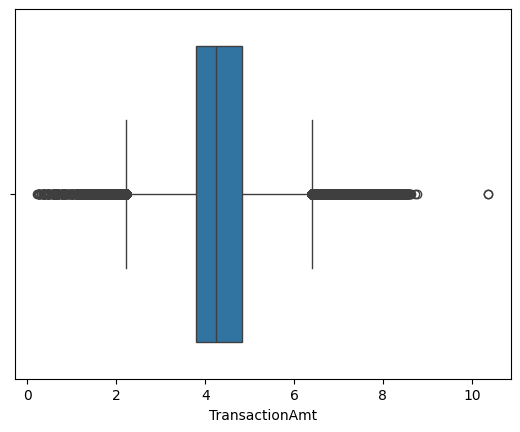

In [6]:
sns.boxplot(x=np.log1p(df['TransactionAmt']))


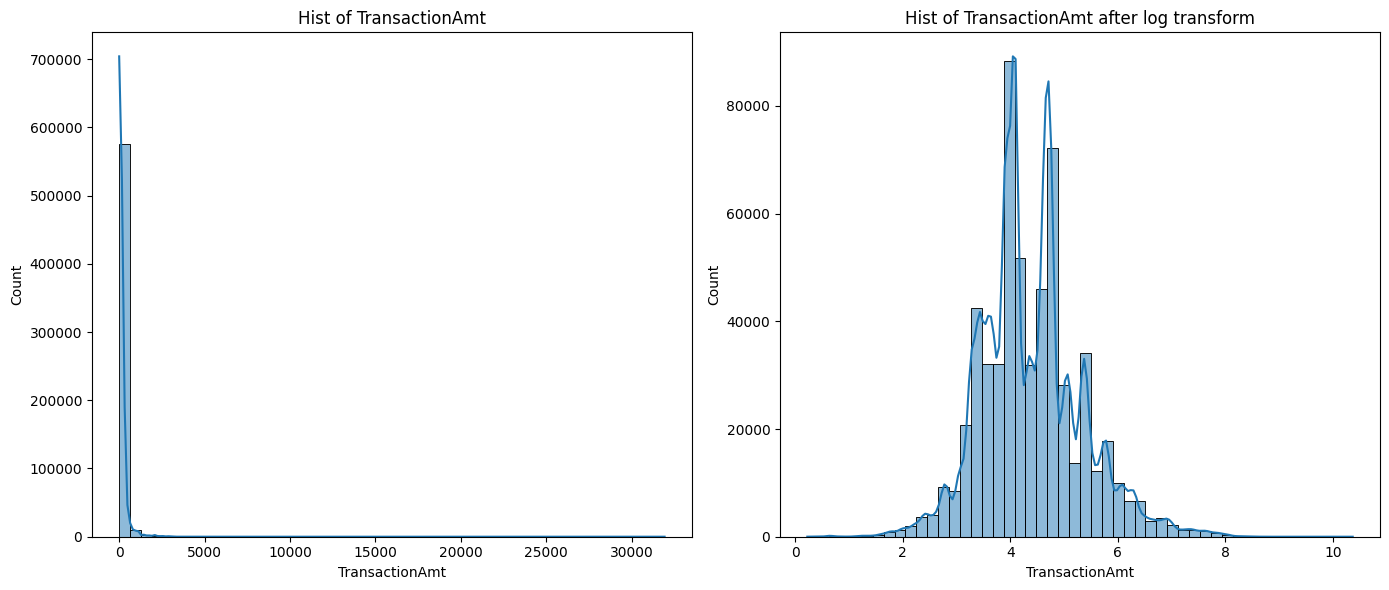

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(df['TransactionAmt'], bins=50, kde=True, ax=axs[0])
axs[0].set_title('Hist of TransactionAmt')

sns.histplot(np.log1p(df['TransactionAmt']), bins=50, kde=True, ax=axs[1])
axs[1].set_title('Hist of TransactionAmt after log transform')

plt.tight_layout()
plt.show()


When training model, log transform this feature before feed to model -> avoid data skewness

## Email Features

In [8]:
for col in ['P_emaildomain', 'R_emaildomain'] :
  col_type =  df[col].dtype
  missing_values = df[col].isnull().sum()
  print(f'{col} is {col_type} and have {missing_values} missing values')

P_emaildomain is object and have 94456 missing values
R_emaildomain is object and have 453249 missing values


- Email have many missing values -> fill it with Unknown

In [9]:
df['R_emaildomain'] = df['R_emaildomain'].fillna('unknown')
df['P_emaildomain'] = df['P_emaildomain'].fillna('unknown')

## Address Features

In [10]:
for col in ['addr1', 'addr2'] :
  col_type =  df[col].dtype
  missing_values = df[col].isnull().sum()
  print(f'{col} is {col_type} and have {missing_values} missing values')

addr1 is float64 and have 65706 missing values
addr2 is float64 and have 65706 missing values


In [11]:
df['addr1'].head(10)

0    315.0
1    325.0
2    330.0
3    476.0
4    420.0
5    272.0
6    126.0
7    325.0
8    337.0
9    204.0
Name: addr1, dtype: float64

- This features is in numerical data but we have to treat them as a categorical data because the numbers are stand for zip code of province or city
- Fill missing value with 'unknown' that stand for unknown value
- Casting to object type
- Using label encoded (1,2 3) before feed it to model

In [12]:
df['addr1'] = df['addr1'].astype('category')
df['addr2'] = df['addr2'].astype('category')


In [13]:
df['addr1'] = df['addr1'].astype('category').astype(str).fillna('unknown')
df['addr2'] = df['addr2'].astype('category').astype(str).fillna('unknown')


- Because they stand for location -> they have no outliers

## Card features

In [14]:
for col in ['card1', 'card2', 'card3', 'card4', 'card5', 'card6'] :
  col_type =  df[col].dtype
  missing_values = df[col].isnull().sum()
  print(f'{col} is {col_type} and have {missing_values} missing values')

card1 is int64 and have 0 missing values
card2 is float64 and have 8933 missing values
card3 is float64 and have 1565 missing values
card4 is object and have 1577 missing values
card5 is float64 and have 4259 missing values
card6 is object and have 1571 missing values


In [15]:
card_nums = ['card1', 'card2', 'card3', 'card5']
card_cats = ['card4' , 'card6']

### Card Num features

- All nums feature in this group are like an cardID , userID rather than an numerical data (can do operations on this) -> so treats it like an categorical data
- Fill missing value with unknown


In [16]:
for col in card_nums:
    df[col] = df[col].astype('category')
    df[col] = df[col].astype('category').astype(str).fillna('unknown')


### Card cat features

In [17]:
for col in card_cats :
  print(f'sample value {col} : {df[col].unique()}')

sample value card4 : ['discover' 'mastercard' 'visa' 'american express' nan]
sample value card6 : ['credit' 'debit' nan 'debit or credit' 'charge card']


In [18]:
for col in card_cats:
    df[col] = df[col].astype('category')
    df[col] = df[col].astype('category').astype(str).fillna('unknown')

### Reduce Card dimension by IV values

C:\Users\LEGION\AppData\Local\Temp\ipykernel_14232\232452123.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=iv_series.index, y=iv_series.values, palette='coolwarm')


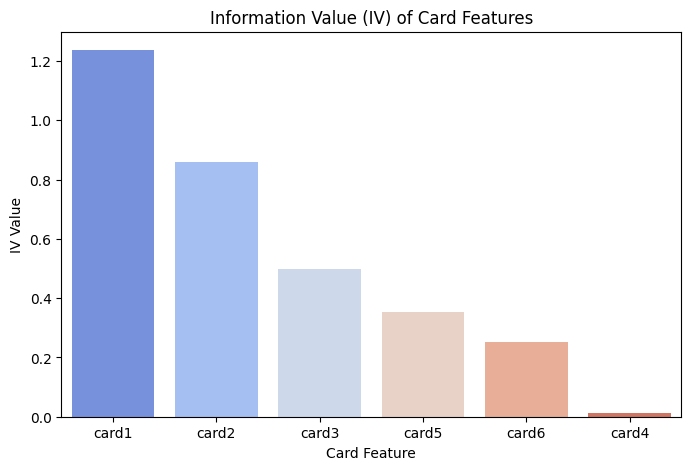

In [19]:
# calculate IV for card features
card_features = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6']
iv_values = {}
for col in card_features:
    iv = calculate_iv(df, col, 'isFraud')
    iv_values[col] = iv
iv_series = pd.Series(iv_values).sort_values(ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x=iv_series.index, y=iv_series.values, palette='coolwarm')
plt.title("Information Value (IV) of Card Features")
plt.xlabel("Card Feature")
plt.ylabel("IV Value")
plt.show()


In [20]:
card_selected = iv_series[(iv_series > 0.3) & (iv_series < 0.5)].index.tolist()
card_selected


['card3', 'card5']

- When eda or modeling just using 2 features

## Counting feature

In [21]:
for col in df.columns :
  if 'C' in col:
    col_type =  df[col].dtype
    missing_values = df[col].isnull().sum()
    print(f'{col} is {col_type} and have {missing_values} missing values')

ProductCD is object and have 0 missing values
C1 is float64 and have 0 missing values
C2 is float64 and have 0 missing values
C3 is float64 and have 0 missing values
C4 is float64 and have 0 missing values
C5 is float64 and have 0 missing values
C6 is float64 and have 0 missing values
C7 is float64 and have 0 missing values
C8 is float64 and have 0 missing values
C9 is float64 and have 0 missing values
C10 is float64 and have 0 missing values
C11 is float64 and have 0 missing values
C12 is float64 and have 0 missing values
C13 is float64 and have 0 missing values
C14 is float64 and have 0 missing values


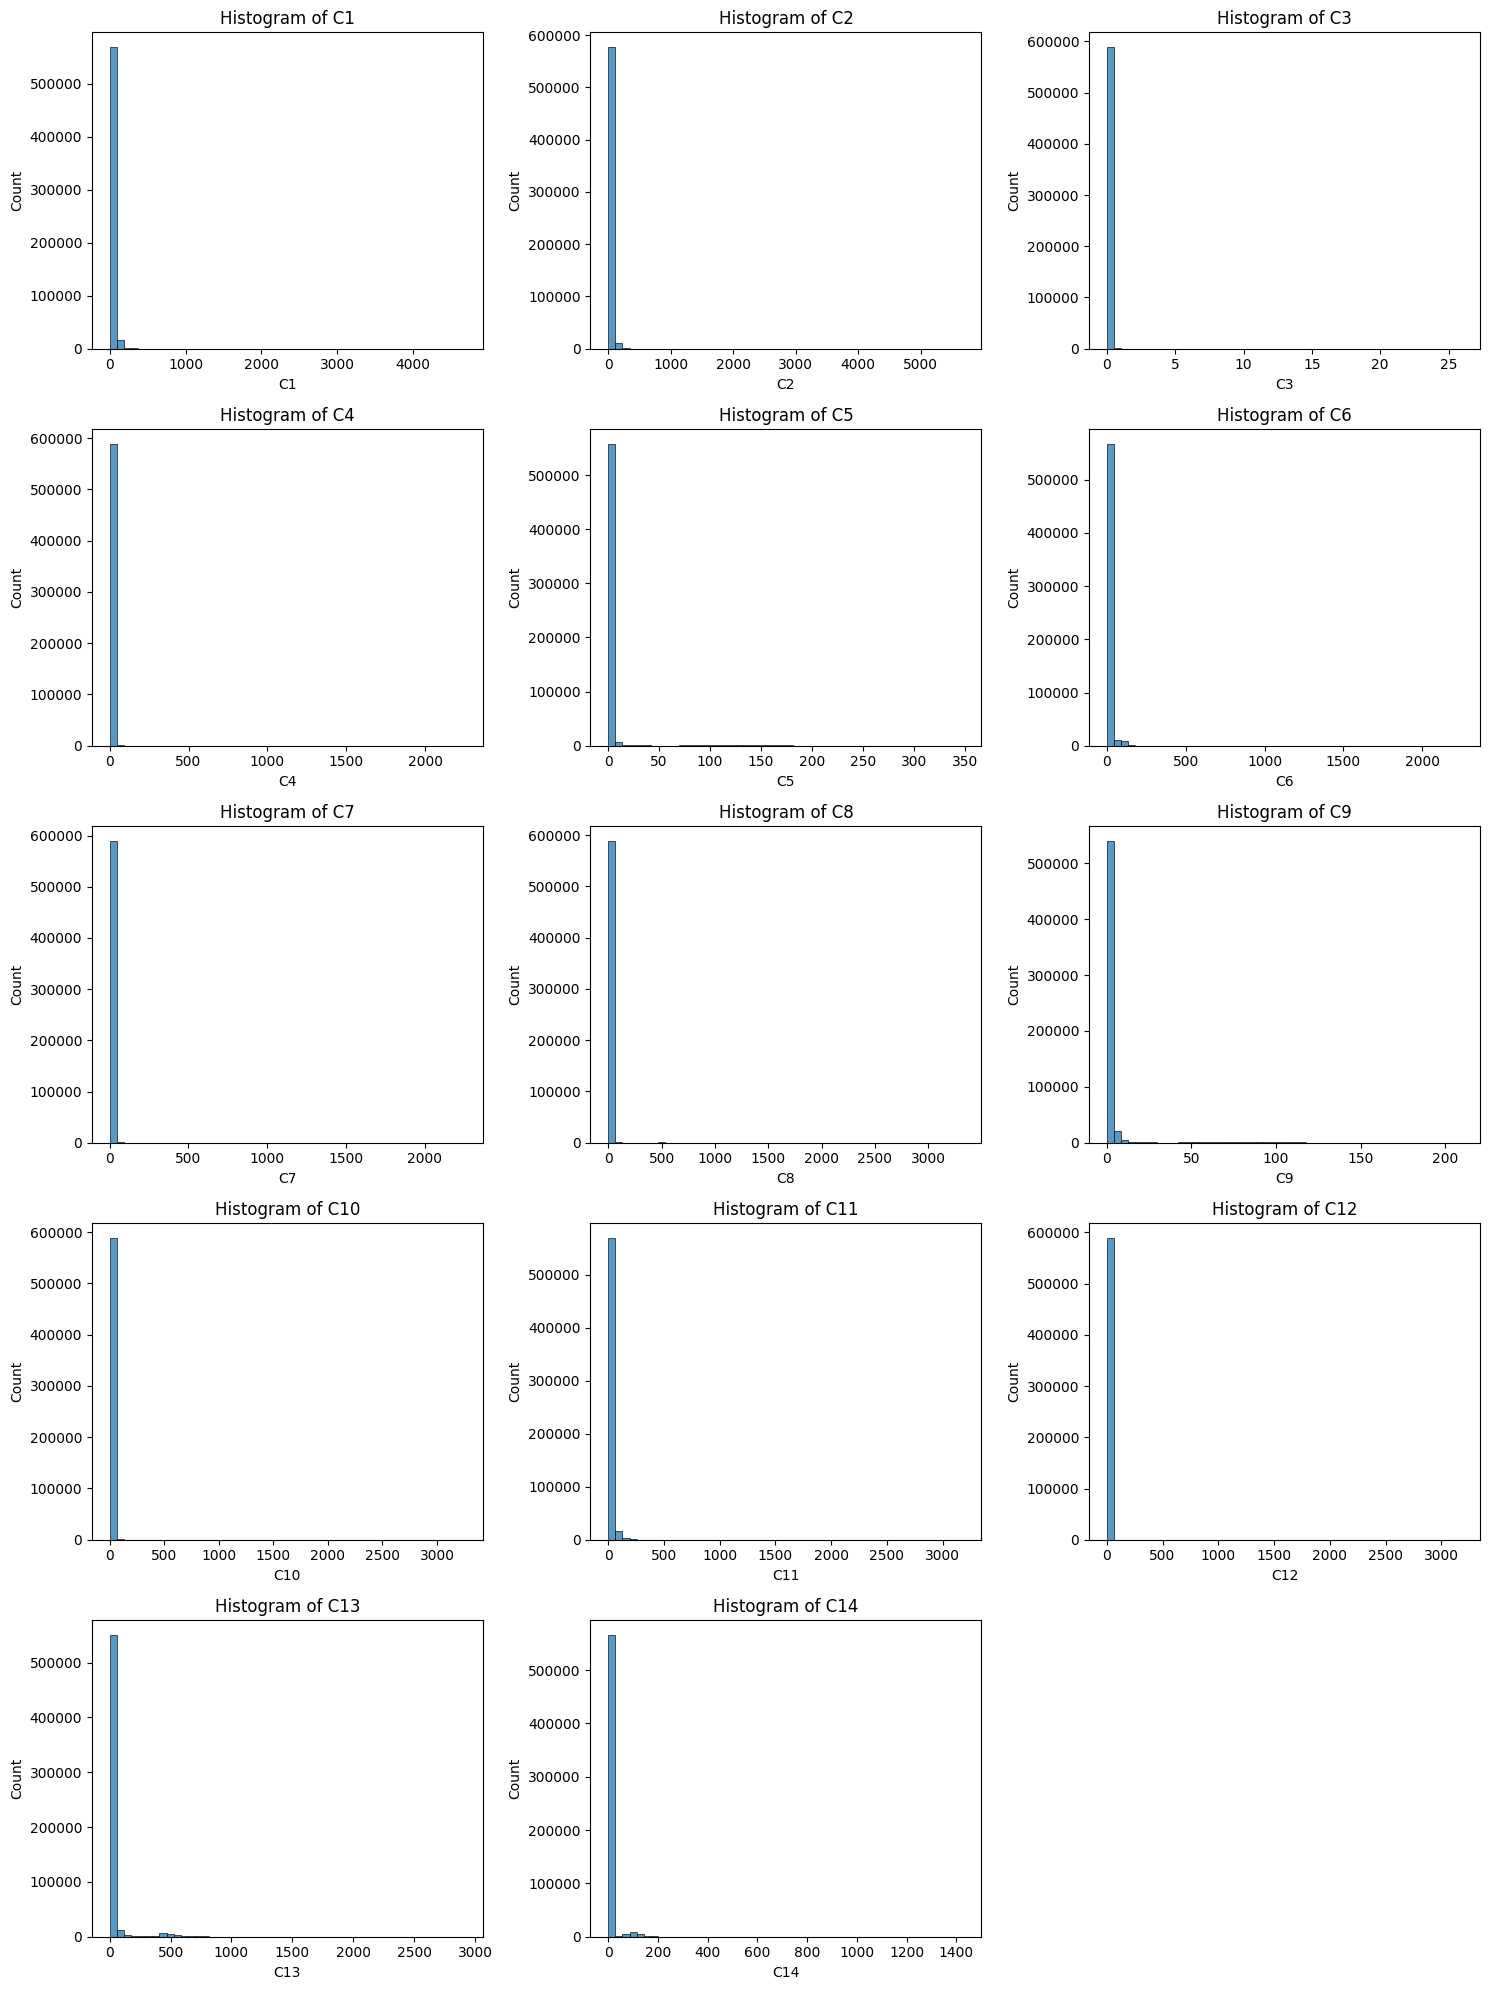

In [22]:

c_cols = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14']

n = len(c_cols)
n_cols = 3
n_rows = (n + n_cols - 1) // n_cols

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))

for i, col in enumerate(c_cols):
    ax = axs[i // n_cols, i % n_cols]
    sns.histplot(df[col], bins=50, kde=False, ax=ax)
    ax.set_title(f'Histogram of {col}')

for j in range(i+1, n_rows*n_cols):
    fig.delaxes(axs[j // n_cols, j % n_cols])

plt.tight_layout()
plt.show()


- All Counting data are skewness -> fillna with median

In [23]:

for col in c_cols:
    df[col] = df[col].fillna(df[col].median())


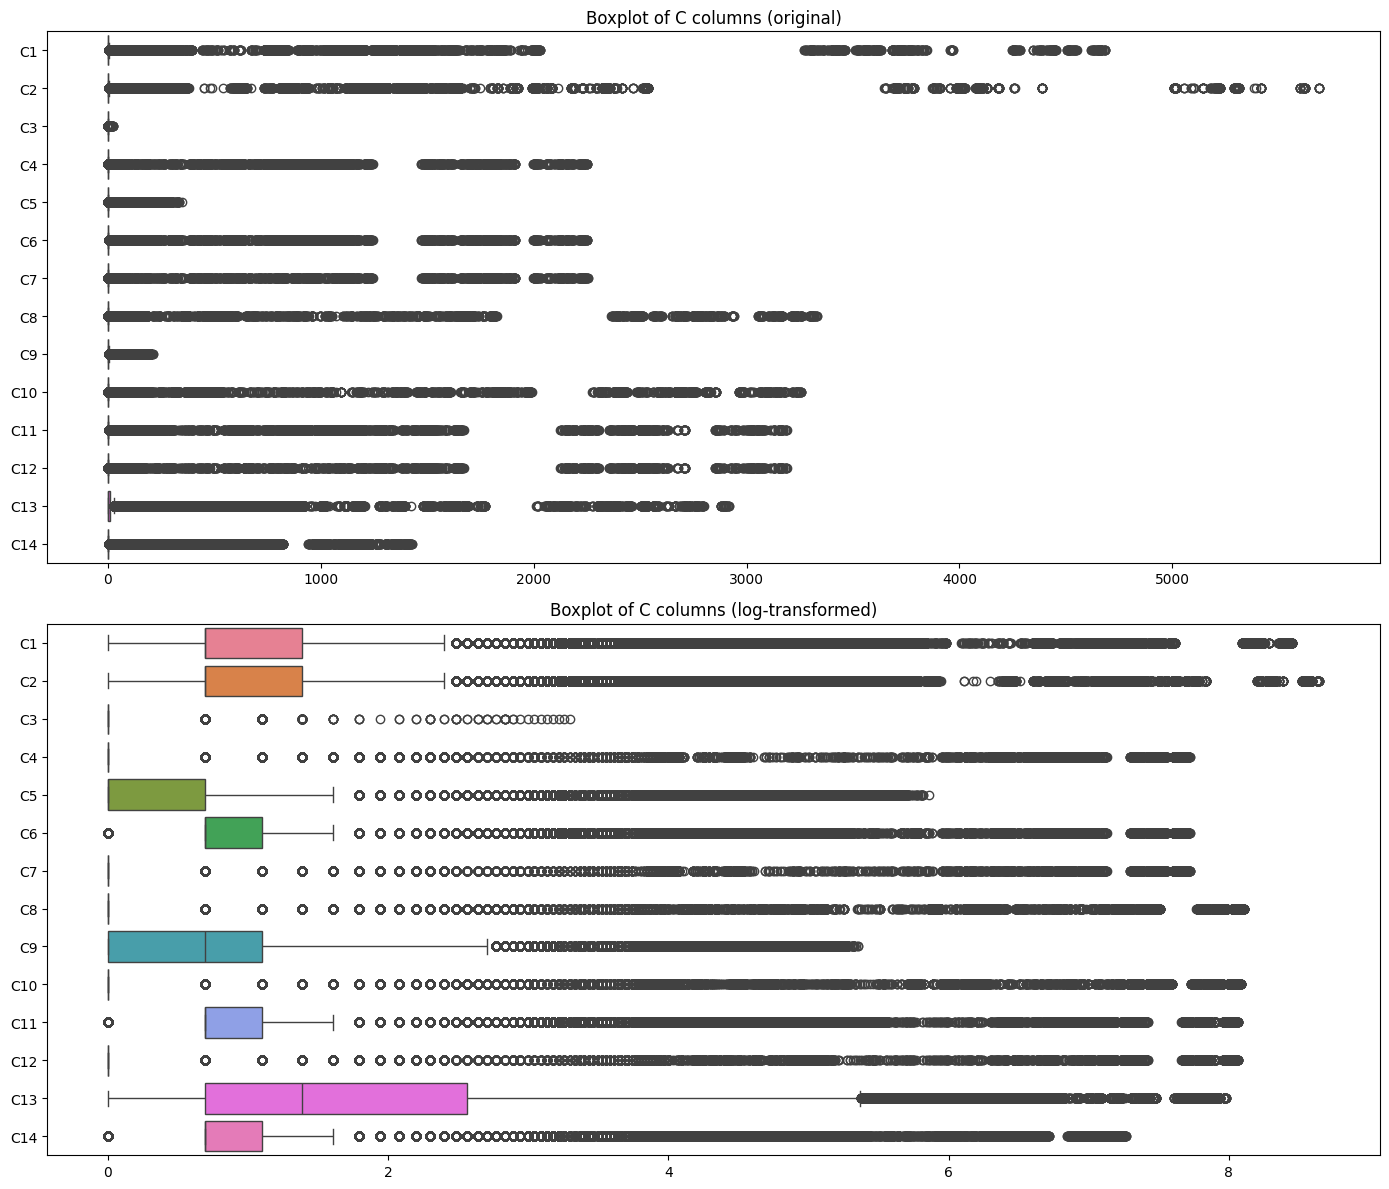

In [24]:


df_log = df[c_cols].apply(lambda x: np.log1p(x))

fig, axs = plt.subplots(2, 1, figsize=(14, 12), sharex=False)

sns.boxplot(data=df[c_cols], orient='h', ax=axs[0])
axs[0].set_title("Boxplot of C columns (original)")

sns.boxplot(data=df_log, orient='h', ax=axs[1])
axs[1].set_title("Boxplot of C columns (log-transformed)")

plt.tight_layout()
plt.show()


- There are so many outliers -> need to scale befor modeling

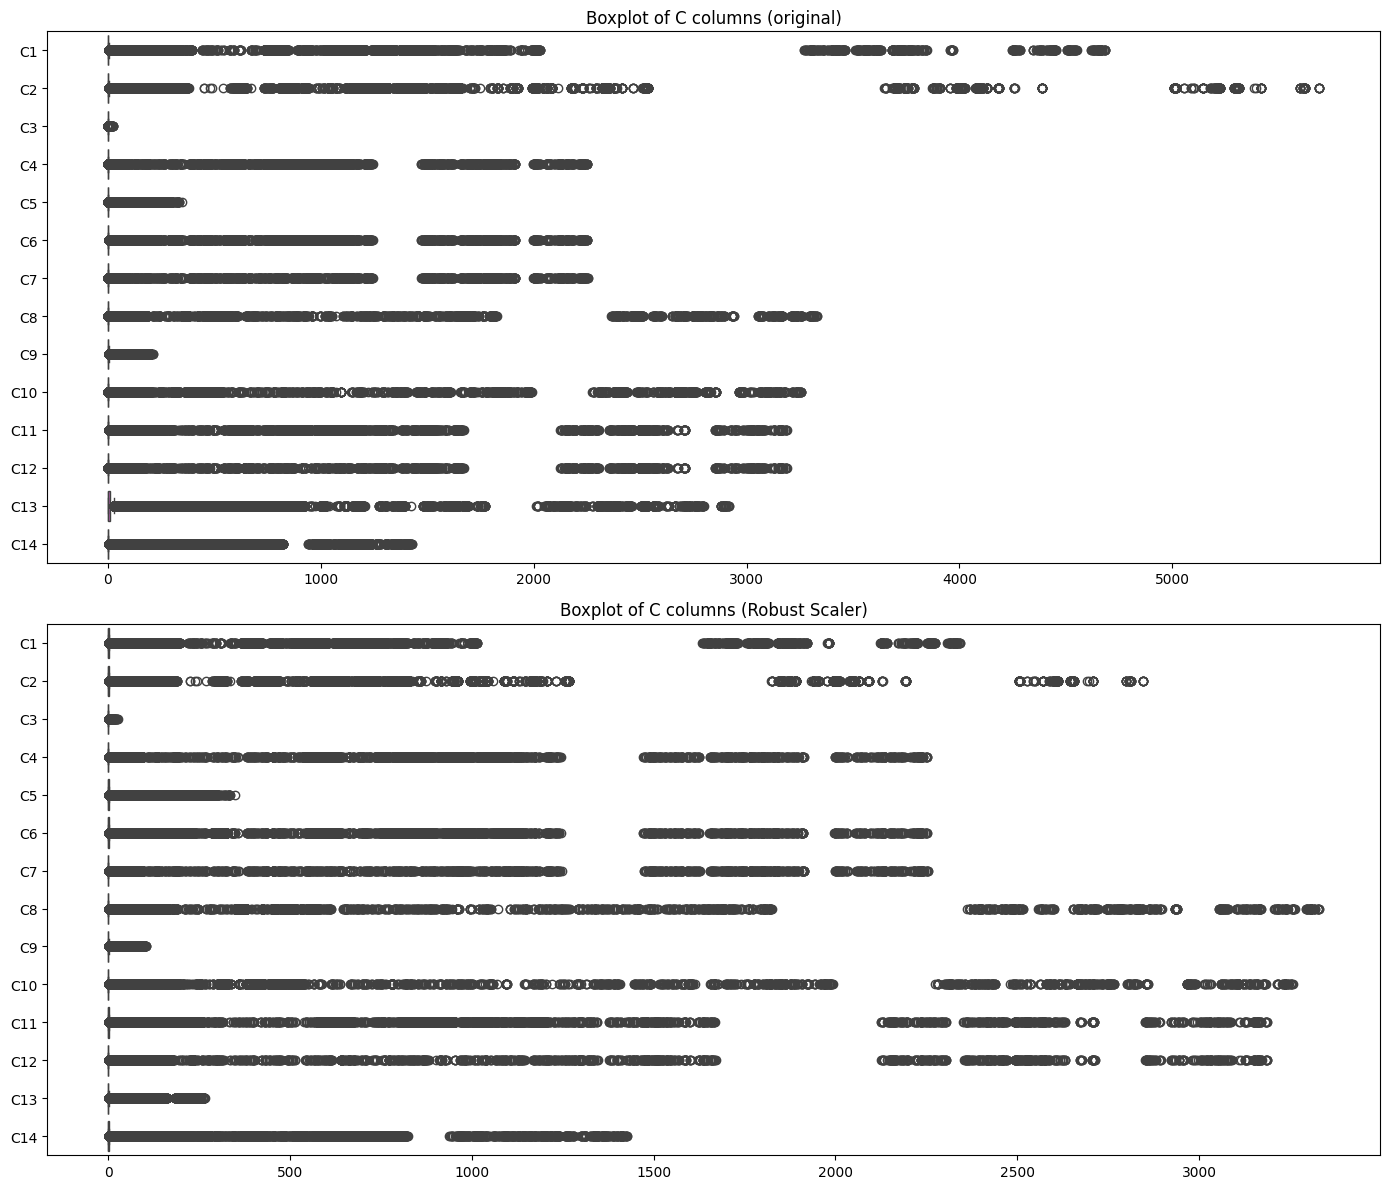

In [25]:

scaler = RobustScaler()
df_robust = pd.DataFrame(scaler.fit_transform(df[c_cols]), columns=c_cols)


fig, axs = plt.subplots(2, 1, figsize=(14, 12), sharex=False)

sns.boxplot(data=df[c_cols], orient='h', ax=axs[0])
axs[0].set_title("Boxplot of C columns (original)")

sns.boxplot(data=df_robust, orient='h', ax=axs[1])
axs[1].set_title("Boxplot of C columns (Robust Scaler)")

plt.tight_layout()
plt.show()


### Reduce counting features with IV value

C:\Users\LEGION\AppData\Local\Temp\ipykernel_14232\2832317408.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=iv_series_counting.index, y=iv_series_counting.values, palette='coolwarm')


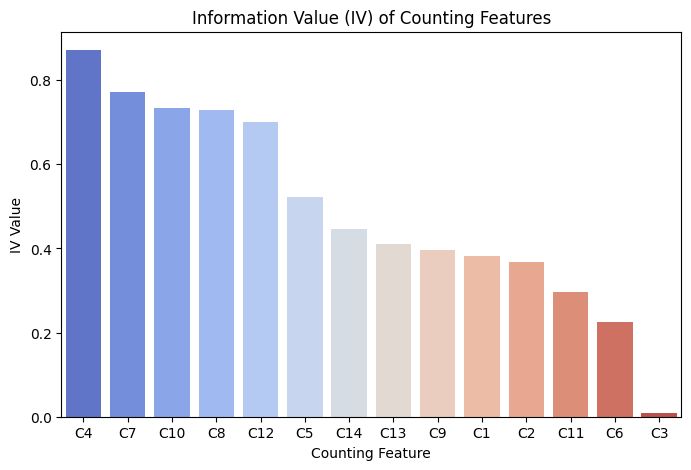

In [26]:
# calculate IV value for counting feature
counting_features = [f'C{i}' for i in range(1, 15)]
iv_values_counting = {}
for col in counting_features:
    iv = calculate_iv(df, col, 'isFraud')
    iv_values_counting[col] = iv
iv_series_counting = pd.Series(iv_values_counting).sort_values(ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x=iv_series_counting.index, y=iv_series_counting.values, palette='coolwarm')
plt.title("Information Value (IV) of Counting Features")
plt.xlabel("Counting Feature")
plt.ylabel("IV Value")
plt.show()

In [27]:
selected_counting_features = iv_series_counting[(iv_series_counting > 0.3) & (iv_series_counting < 0.5)].index.tolist()
selected_counting_features

['C14', 'C13', 'C9', 'C1', 'C2']

- Use these feature for futher processing and modeling

## Time Delta Features (D1–D15)





In [28]:
time_dt_cols = [f'D{i}' for i in range(1, 16)]

In [29]:
for col in time_dt_cols :
  col_type =  df[col].dtype
  missing_values = df[col].isnull().sum()
  print(f'{col} is {col_type} and have {missing_values} missing values')


D1 is float64 and have 1269 missing values
D2 is float64 and have 280797 missing values
D3 is float64 and have 262878 missing values
D4 is float64 and have 168922 missing values
D5 is float64 and have 309841 missing values
D6 is float64 and have 517353 missing values
D7 is float64 and have 551623 missing values
D8 is float64 and have 515614 missing values
D9 is float64 and have 515614 missing values
D10 is float64 and have 76022 missing values
D11 is float64 and have 279287 missing values
D12 is float64 and have 525823 missing values
D13 is float64 and have 528588 missing values
D14 is float64 and have 528353 missing values
D15 is float64 and have 89113 missing values


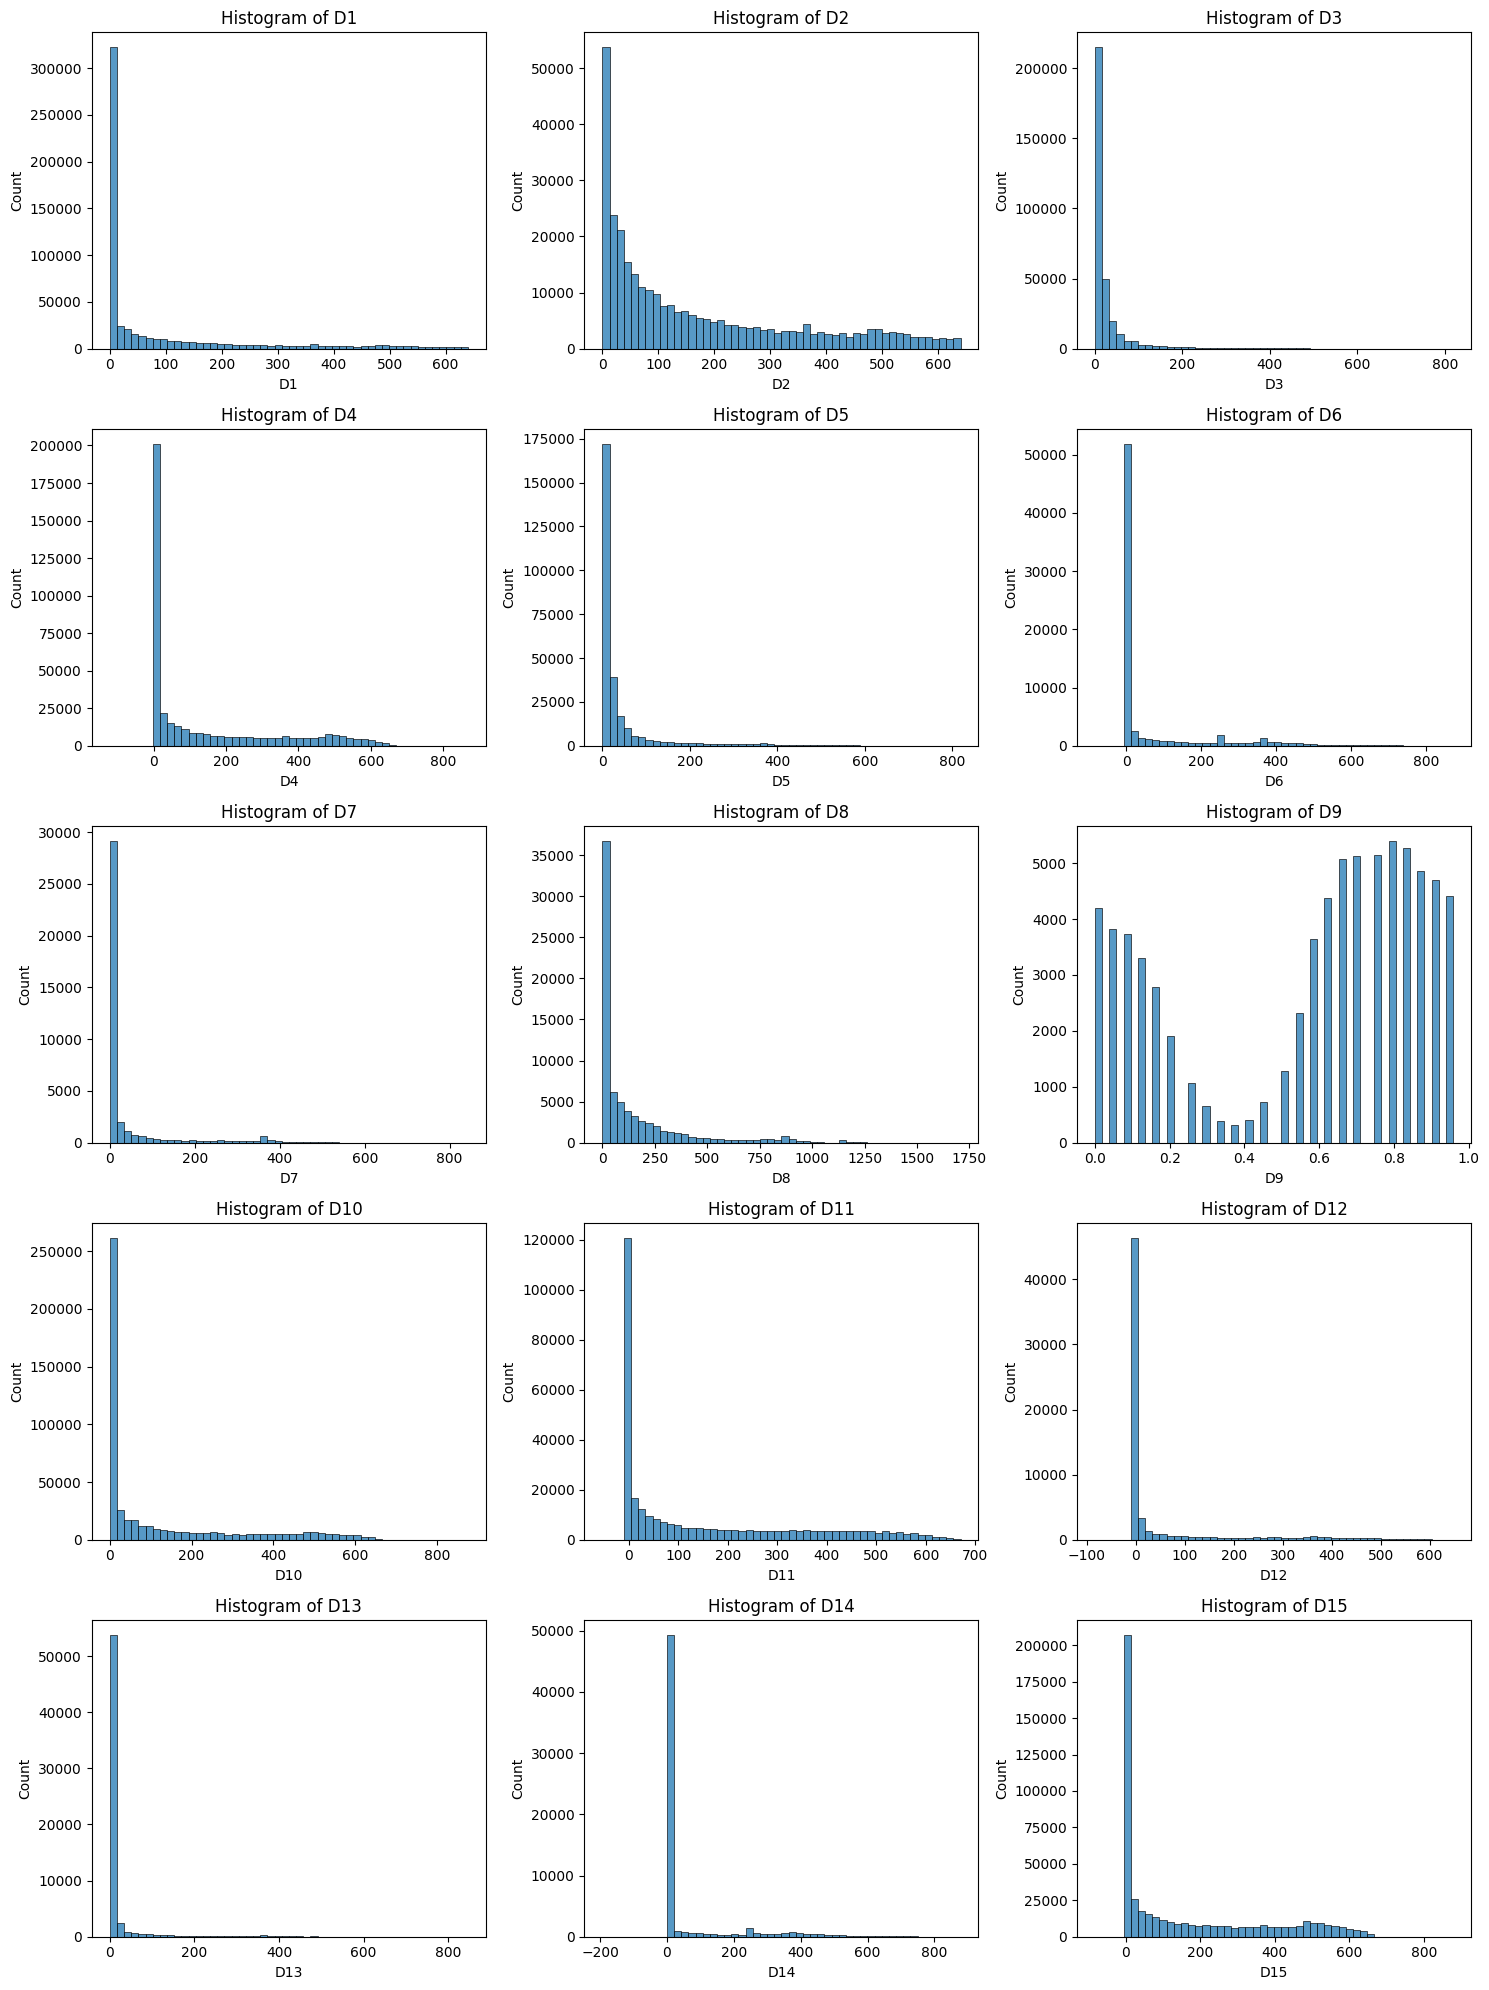

In [30]:
n = len(time_dt_cols)
n_cols = 3
n_rows = (n + n_cols - 1) // n_cols

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))

for i, col in enumerate(time_dt_cols):
    ax = axs[i // n_cols, i % n_cols]
    sns.histplot(df[col].dropna(), bins=50, kde=False, ax=ax)
    ax.set_title(f'Histogram of {col}')

for j in range(i+1, n_rows*n_cols):
    fig.delaxes(axs[j // n_cols, j % n_cols])

plt.tight_layout()
plt.show()

- D9 may be an probability -> binning to 0 , 1 -> treat it like an categorical data. Fill missing value with -1 stand for unkown

In [31]:
df['D9'] = df['D9'].fillna(-1).apply(lambda x: -1 if x == -1 else (1 if x >= 0.5 else 0))
df['D9'] = df['D9'].astype('category')


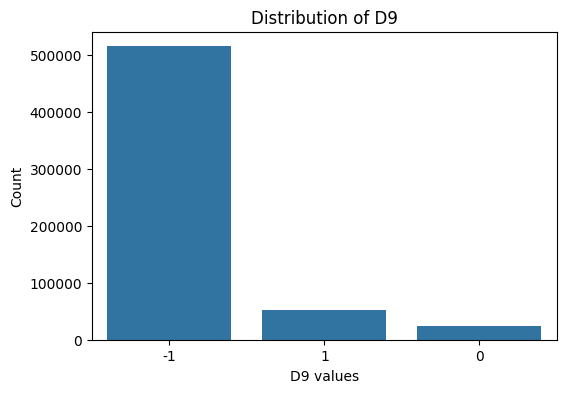

In [32]:
counts = df['D9'].value_counts(dropna=False)

plt.figure(figsize=(6,4))
sns.barplot(x=counts.index.astype(str), y=counts.values)
plt.title("Distribution of D9")
plt.xlabel("D9 values")
plt.ylabel("Count")
plt.show()

- Other numericals fillna with median

In [33]:
for col in time_dt_cols:
    if col != 'D9':
        df[col] = df[col].fillna(df[col].median())


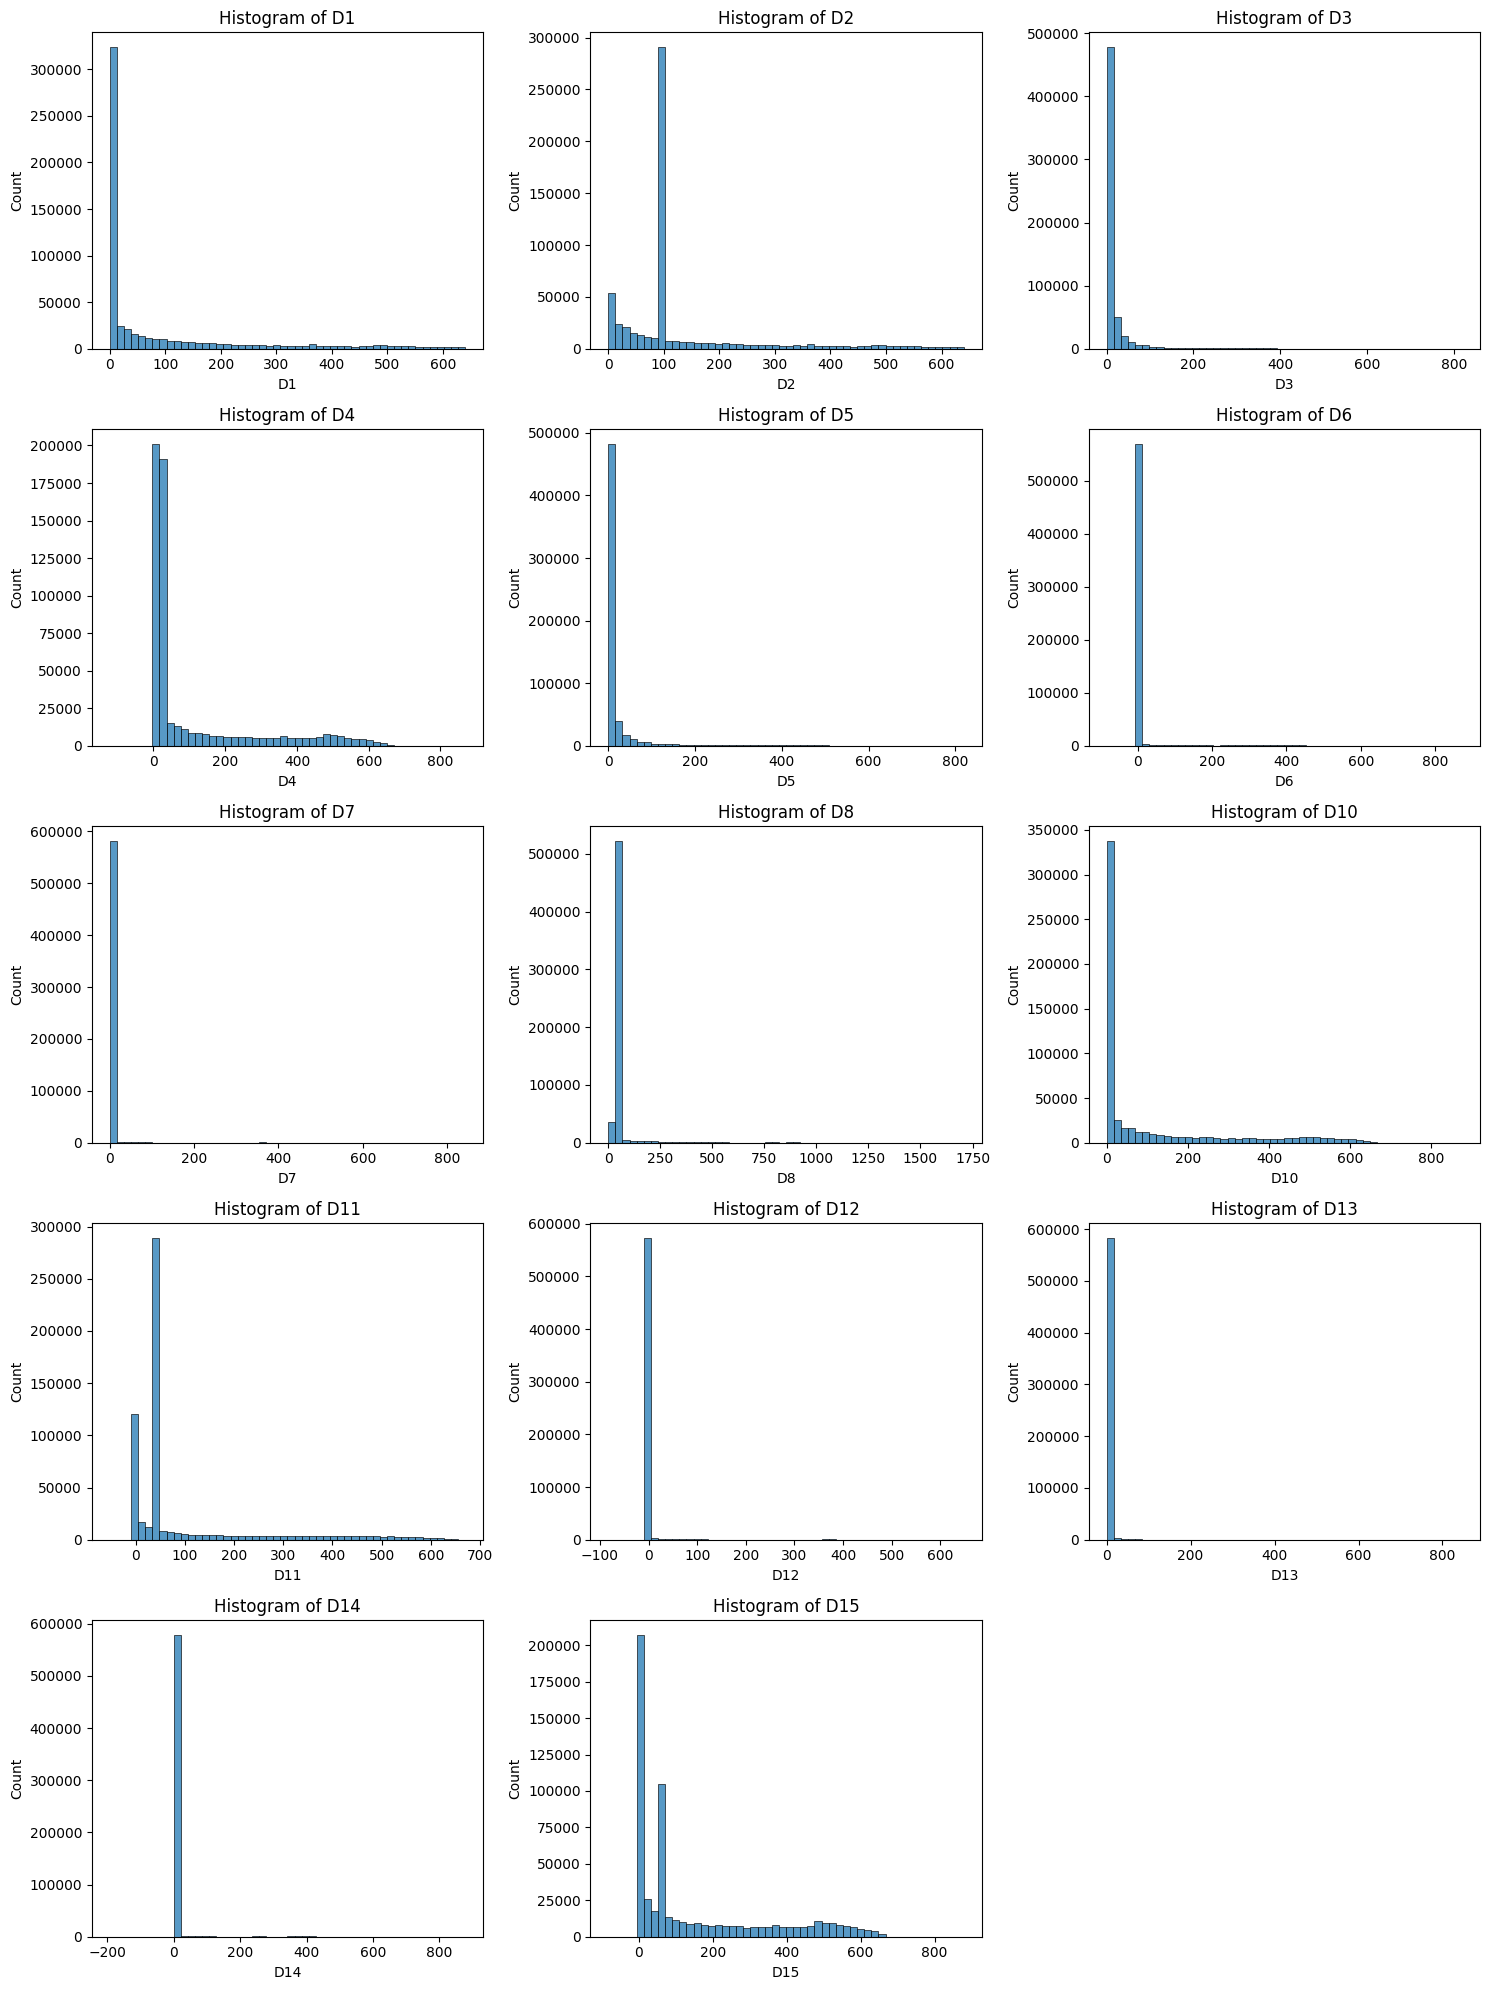

In [34]:

plot_cols = [col for col in time_dt_cols if col != 'D9']

n = len(plot_cols)
n_cols = 3
n_rows = (n + n_cols - 1) // n_cols

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))

for i, col in enumerate(plot_cols):
    ax = axs[i // n_cols, i % n_cols]
    sns.histplot(df[col], bins=50, kde=False, ax=ax)
    ax.set_title(f'Histogram of {col}')

for j in range(i+1, n_rows*n_cols):
    fig.delaxes(axs[j // n_cols, j % n_cols])

plt.tight_layout()
plt.show()


d:\Work\Fraud_detection\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
d:\Work\Fraud_detection\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


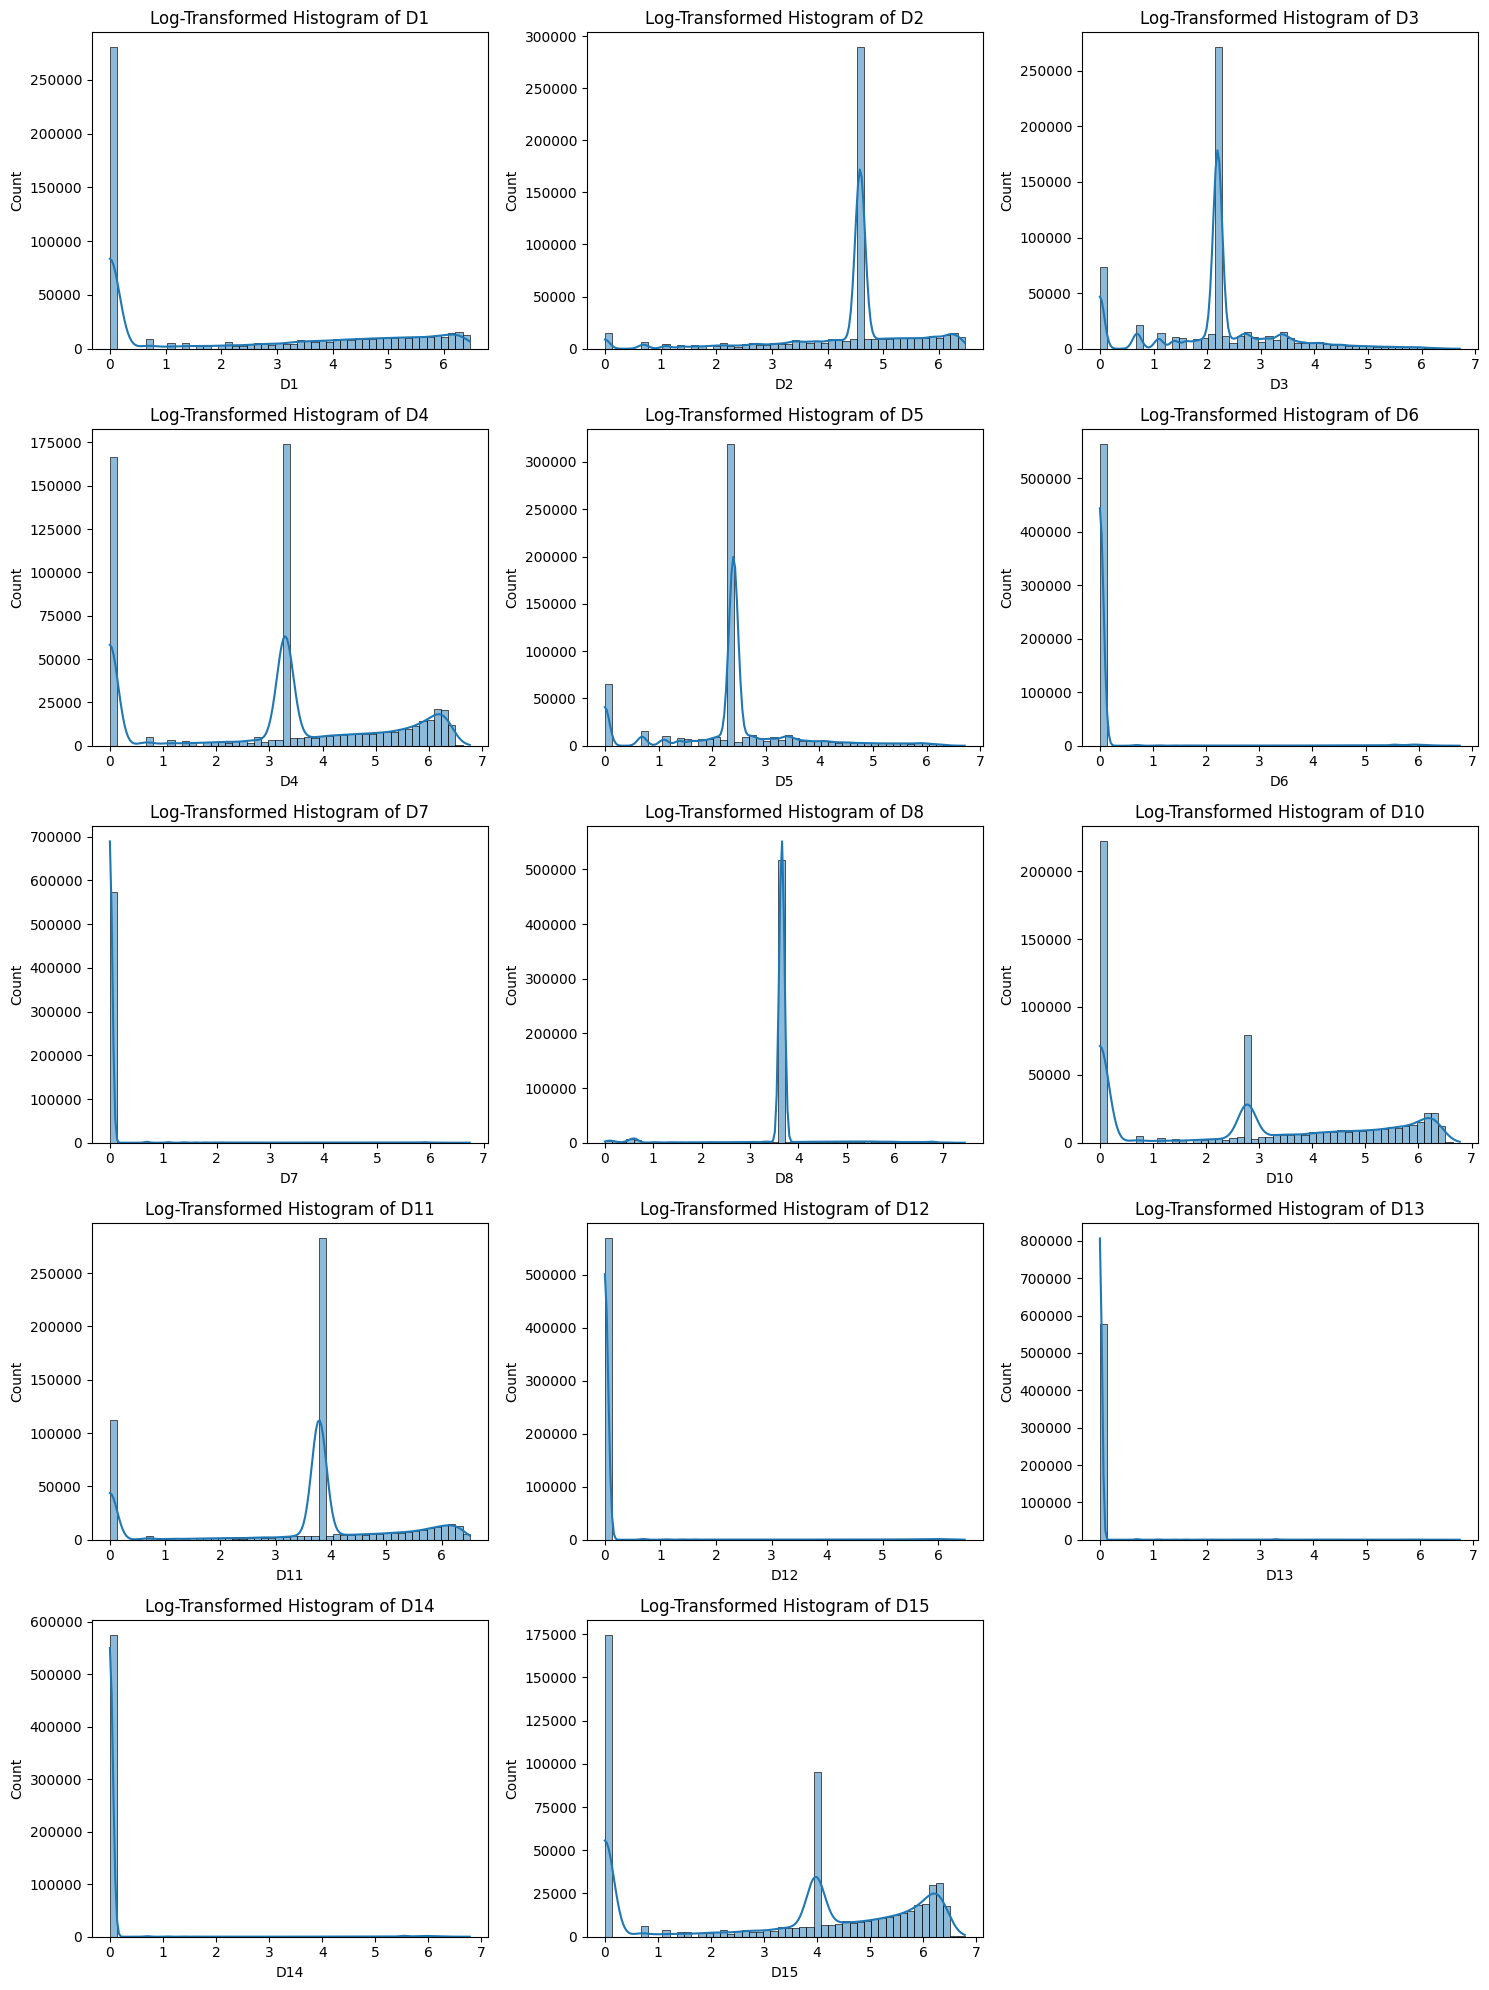

In [35]:

df_log = df[plot_cols].apply(lambda x: np.log1p(x))

n = len(plot_cols)
n_cols = 3
n_rows = (n + n_cols - 1) // n_cols

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))

for i, col in enumerate(plot_cols):
    ax = axs[i // n_cols, i % n_cols]
    sns.histplot(df_log[col], bins=50, kde=True, ax=ax)
    ax.set_title(f'Log-Transformed Histogram of {col}')

for j in range(i+1, n_rows*n_cols):
    fig.delaxes(axs[j // n_cols, j % n_cols])

plt.tight_layout()
plt.show()

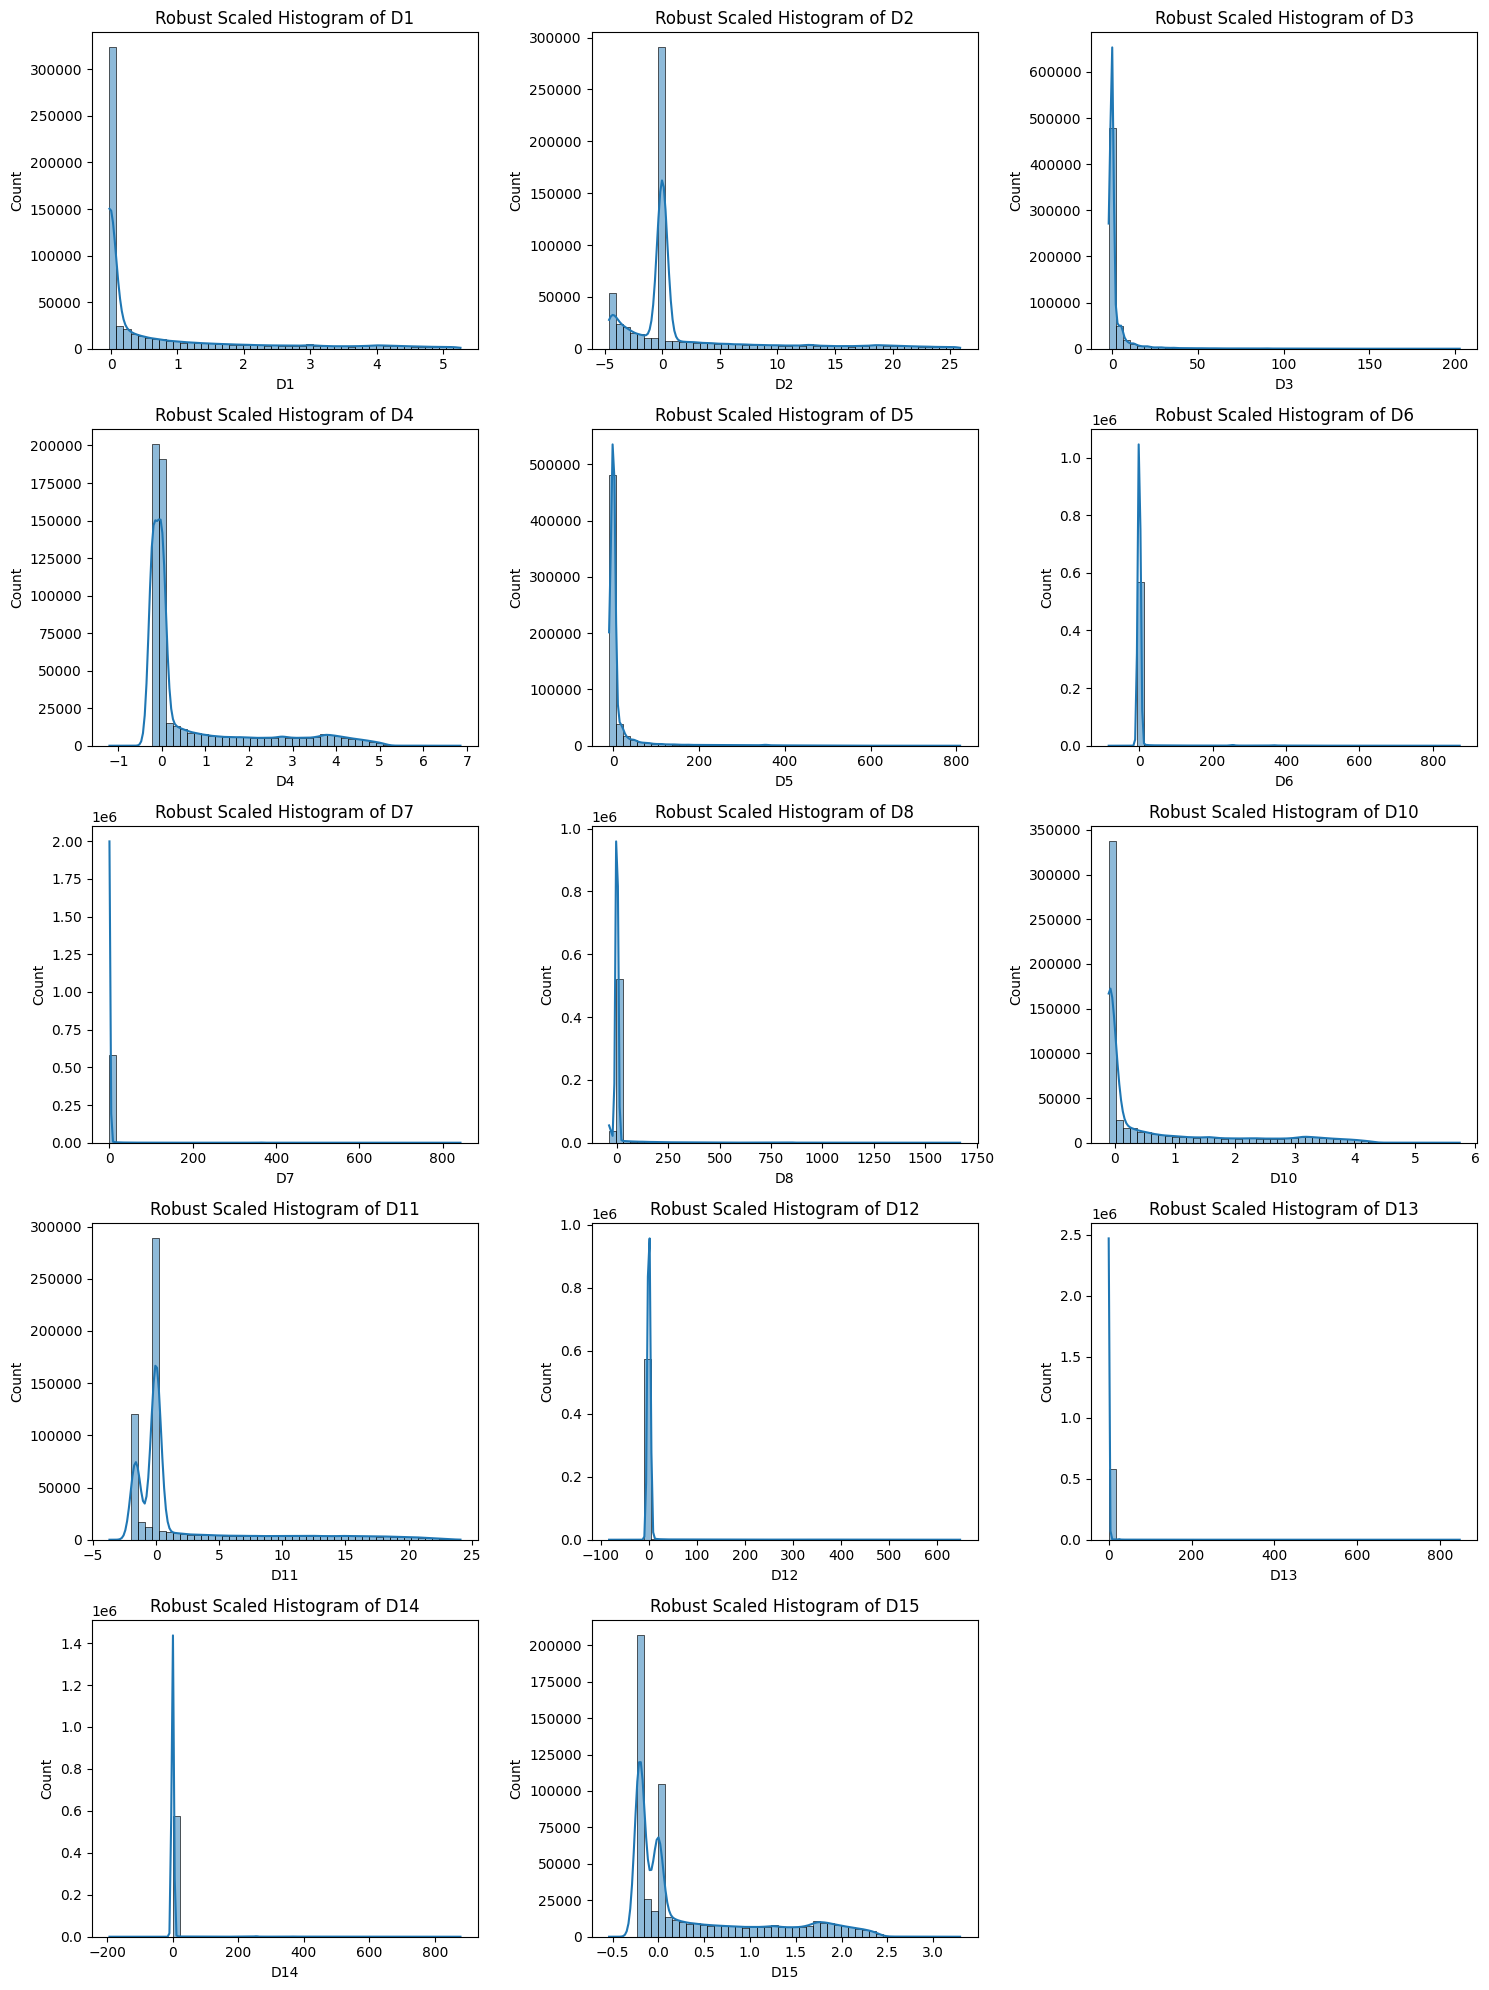

In [36]:

scaler = RobustScaler()
df_robust = pd.DataFrame(scaler.fit_transform(df[plot_cols]), columns=plot_cols)

n = len(plot_cols)
n_cols = 3
n_rows = (n + n_cols - 1) // n_cols

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))

for i, col in enumerate(plot_cols):
    ax = axs[i // n_cols, i % n_cols]
    sns.histplot(df_robust[col], bins=50, kde=True, ax=ax)
    ax.set_title(f'Robust Scaled Histogram of {col}')

for j in range(i+1, n_rows*n_cols):
    fig.delaxes(axs[j // n_cols, j % n_cols])

plt.tight_layout()
plt.show()




### Reduce dimension with IV

C:\Users\LEGION\AppData\Local\Temp\ipykernel_14232\2537667097.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=iv_series_dt.index, y=iv_series_dt.values, palette='coolwarm')


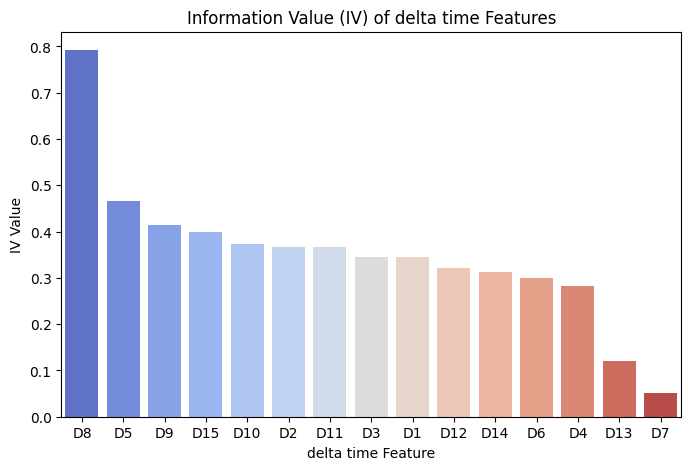

In [37]:
# Calculate IV feature
d_cols = time_dt_cols
iv_values_delta_time = {}
for col in d_cols:
    iv = calculate_iv(df, col, 'isFraud')
    iv_values_delta_time[col] = iv
iv_series_dt = pd.Series(iv_values_delta_time).sort_values(ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x=iv_series_dt.index, y=iv_series_dt.values, palette='coolwarm')
plt.title("Information Value (IV) of delta time Features")
plt.xlabel("delta time Feature")
plt.ylabel("IV Value")
plt.show()


In [38]:
# filter C features with IV > 0.3 and IV < 0.5
selected_dt_features = iv_series_dt[(iv_series_dt > 0.3) & (iv_series_dt < 0.5)].index.tolist()
selected_dt_features


['D5', 'D9', 'D15', 'D10', 'D2', 'D11', 'D3', 'D1', 'D12', 'D14']

- Use their feature for futher eda or modeling

## Matching features

In [39]:
m_cols = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']

In [40]:
for col in m_cols :
  col_type =  df[col].dtype
  missing_values = df[col].isnull().sum()
  print(f'{col} is {col_type} and have {missing_values} missing values')
  print(f'{col} sample values : {df[col].unique()}')

M1 is object and have 271100 missing values
M1 sample values : ['T' nan 'F']
M2 is object and have 271100 missing values
M2 sample values : ['T' nan 'F']
M3 is object and have 271100 missing values
M3 sample values : ['T' nan 'F']
M4 is object and have 281444 missing values
M4 sample values : ['M2' 'M0' nan 'M1']
M5 is object and have 350482 missing values
M5 sample values : ['F' 'T' nan]
M6 is object and have 169360 missing values
M6 sample values : ['T' 'F' nan]
M7 is object and have 346265 missing values
M7 sample values : [nan 'F' 'T']
M8 is object and have 346252 missing values
M8 sample values : [nan 'F' 'T']
M9 is object and have 346252 missing values
M9 sample values : [nan 'F' 'T']


In [41]:
for col in m_cols :
  df[col].fillna('unknown', inplace=True)

C:\Users\LEGION\AppData\Local\Temp\ipykernel_14232\3338746949.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna('unknown', inplace=True)


### Reduce dimension with IV

C:\Users\LEGION\AppData\Local\Temp\ipykernel_14232\1679414070.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=iv_series_m.index, y=iv_series_m.values, palette='coolwarm')


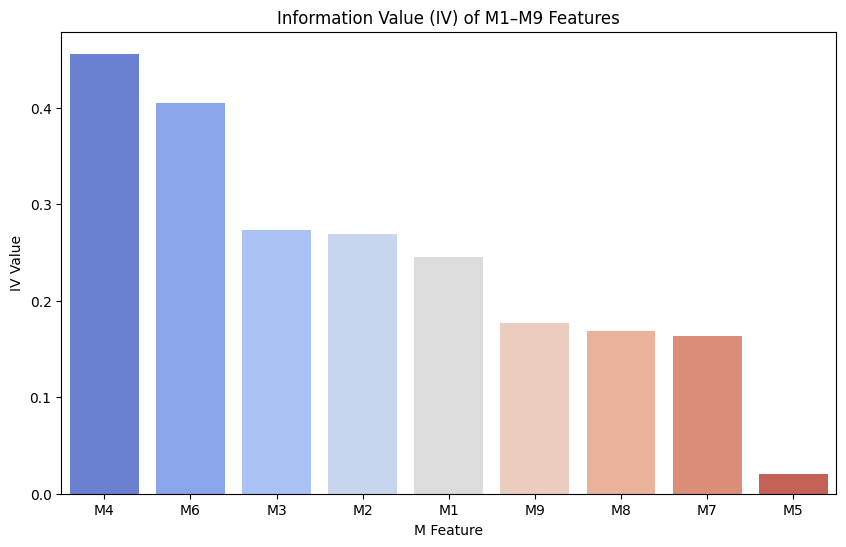

In [42]:

m_cols = [col for col in df.columns if col.startswith('M')]


iv_values_m = {}
for col in m_cols:
    iv = calculate_iv(df, col, 'isFraud')
    iv_values_m[col] = iv

iv_series_m = pd.Series(iv_values_m).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=iv_series_m.index, y=iv_series_m.values, palette='coolwarm')
plt.title("Information Value (IV) of M1–M9 Features")
plt.xlabel("M Feature")
plt.ylabel("IV Value")
plt.show()



In [43]:
# filter C features with IV > 0.3 and IV < 0.5
iv_series_m = iv_series_m[(iv_series_m > 0.3) & (iv_series_m < 0.5)].index.tolist()
iv_series_m

['M4', 'M6']

## V columns

In [44]:
v_cols = [col for col in df.columns if 'V' in col]

In [45]:
for col in v_cols :
  if df[col].isnull().sum() != 0 :
    col_type =  df[col].dtype
    missing_values = df[col].isnull().sum()
    print(f'{col} is {col_type} and have {missing_values} missing values')
    # print(f'{col} sample values : {df[col].unique()}')

V1 is float64 and have 279287 missing values
V2 is float64 and have 279287 missing values
V3 is float64 and have 279287 missing values
V4 is float64 and have 279287 missing values
V5 is float64 and have 279287 missing values
V6 is float64 and have 279287 missing values
V7 is float64 and have 279287 missing values
V8 is float64 and have 279287 missing values
V9 is float64 and have 279287 missing values
V10 is float64 and have 279287 missing values
V11 is float64 and have 279287 missing values
V12 is float64 and have 76073 missing values
V13 is float64 and have 76073 missing values
V14 is float64 and have 76073 missing values
V15 is float64 and have 76073 missing values
V16 is float64 and have 76073 missing values
V17 is float64 and have 76073 missing values
V18 is float64 and have 76073 missing values
V19 is float64 and have 76073 missing values
V20 is float64 and have 76073 missing values
V21 is float64 and have 76073 missing values
V22 is float64 and have 76073 missing values
V23 is f

In [46]:
for col in v_cols :
  df[col]= df[col].fillna(-1 )

In [47]:
v_cols = [col for col in df.columns if col.startswith('V')]

iv_values_v = {}
for col in v_cols:
    iv = calculate_iv(df, col, 'isFraud')
    iv_values_v[col] = iv

iv_series_v = pd.Series(iv_values_v).sort_values(ascending=False)

iv_filtered = iv_series_v[(iv_series_v > 0.3) & (iv_series_v < 0.5)]


In [48]:
iv_filtered

V85     0.498704
V211    0.497634
V254    0.497061
V262    0.496119
V214    0.495091
V48     0.493498
V32     0.490824
V31     0.490718
V84     0.490316
V22     0.489356
V267    0.488546
V180    0.487880
V21     0.487140
V213    0.486842
V277    0.486027
V72     0.484484
V239    0.484162
V43     0.482833
V184    0.482310
V182    0.480896
V183    0.480032
V253    0.476931
V185    0.475484
V205    0.474768
V212    0.473942
V60     0.473112
V50     0.472775
V278    0.469069
V303    0.468442
V42     0.468109
V181    0.467548
V238    0.464946
V71     0.464037
V59     0.462195
V236    0.462095
V310    0.461726
V206    0.459925
V64     0.459910
V268    0.457509
V260    0.456931
V317    0.456343
V276    0.455843
V304    0.454066
V63     0.451240
V175    0.447066
V169    0.445640
V127    0.444243
V237    0.441833
V302    0.440113
V273    0.428749
V174    0.428231
V220    0.427117
V173    0.426824
V172    0.426719
V227    0.422914
V274    0.422198
V266    0.421716
V235    0.420726
V275    0.4161

## Identity Features

In [49]:
df['DeviceType'].isnull().sum()

np.int64(449730)

In [50]:
df['DeviceType'].dtype

dtype('O')

In [51]:
df['DeviceType'] =  df['DeviceType'].fillna('unkown')

C:\Users\LEGION\AppData\Local\Temp\ipykernel_14232\1124161241.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette='viridis')


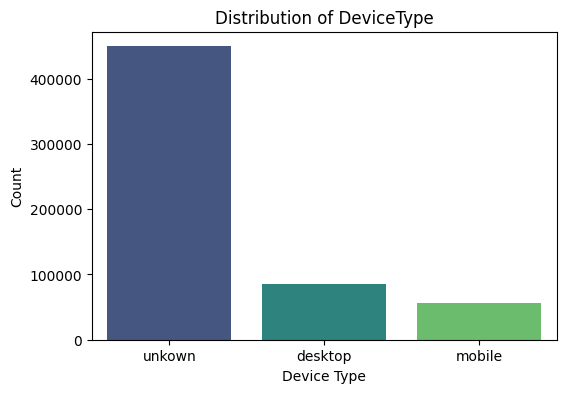

In [52]:

counts = df['DeviceType'].value_counts()

plt.figure(figsize=(6,4))
sns.barplot(x=counts.index, y=counts.values, palette='viridis')
plt.title("Distribution of DeviceType")
plt.xlabel("Device Type")
plt.ylabel("Count")
plt.show()


## DeviceInfo

In [53]:
df['DeviceInfo'].isnull().sum()

np.int64(471874)

In [54]:
df['DeviceInfo'] =  df['DeviceInfo'].fillna('unkown')

In [55]:
df['DeviceInfo'].unique()

array(['unkown', 'SAMSUNG SM-G892A Build/NRD90M', 'iOS Device', ...,
       'LDN-LX3 Build/HUAWEILDN-LX3', 'Z955A', 'LG-E975'],
      shape=(1787,), dtype=object)

## ID_x

In [56]:
id_cols = [col for col in df.columns if 'id' in col]

In [57]:
for col in id_cols :
  col_type =  df[col].dtype
  missing_values = df[col].isnull().sum()
  print(f'{col} is {col_type} and have {missing_values} missing values')

id_01 is float64 and have 446307 missing values
id_02 is float64 and have 449668 missing values
id_03 is float64 and have 524216 missing values
id_04 is float64 and have 524216 missing values
id_05 is float64 and have 453675 missing values
id_06 is float64 and have 453675 missing values
id_07 is float64 and have 585385 missing values
id_08 is float64 and have 585385 missing values
id_09 is float64 and have 515614 missing values
id_10 is float64 and have 515614 missing values
id_11 is float64 and have 449562 missing values
id_12 is object and have 446307 missing values
id_13 is float64 and have 463220 missing values
id_14 is float64 and have 510496 missing values
id_15 is object and have 449555 missing values
id_16 is object and have 461200 missing values
id_17 is float64 and have 451171 missing values
id_18 is float64 and have 545427 missing values
id_19 is float64 and have 451222 missing values
id_20 is float64 and have 451279 missing values
id_21 is float64 and have 585381 missing va

In [58]:
id_nums_cols = [col for col in id_cols if df[col].dtype == np.float64 ]
id_cat_cols = [col for col in id_cols  if df[col].dtype == object]

In [59]:
len(id_nums_cols) + len(id_cat_cols)

38

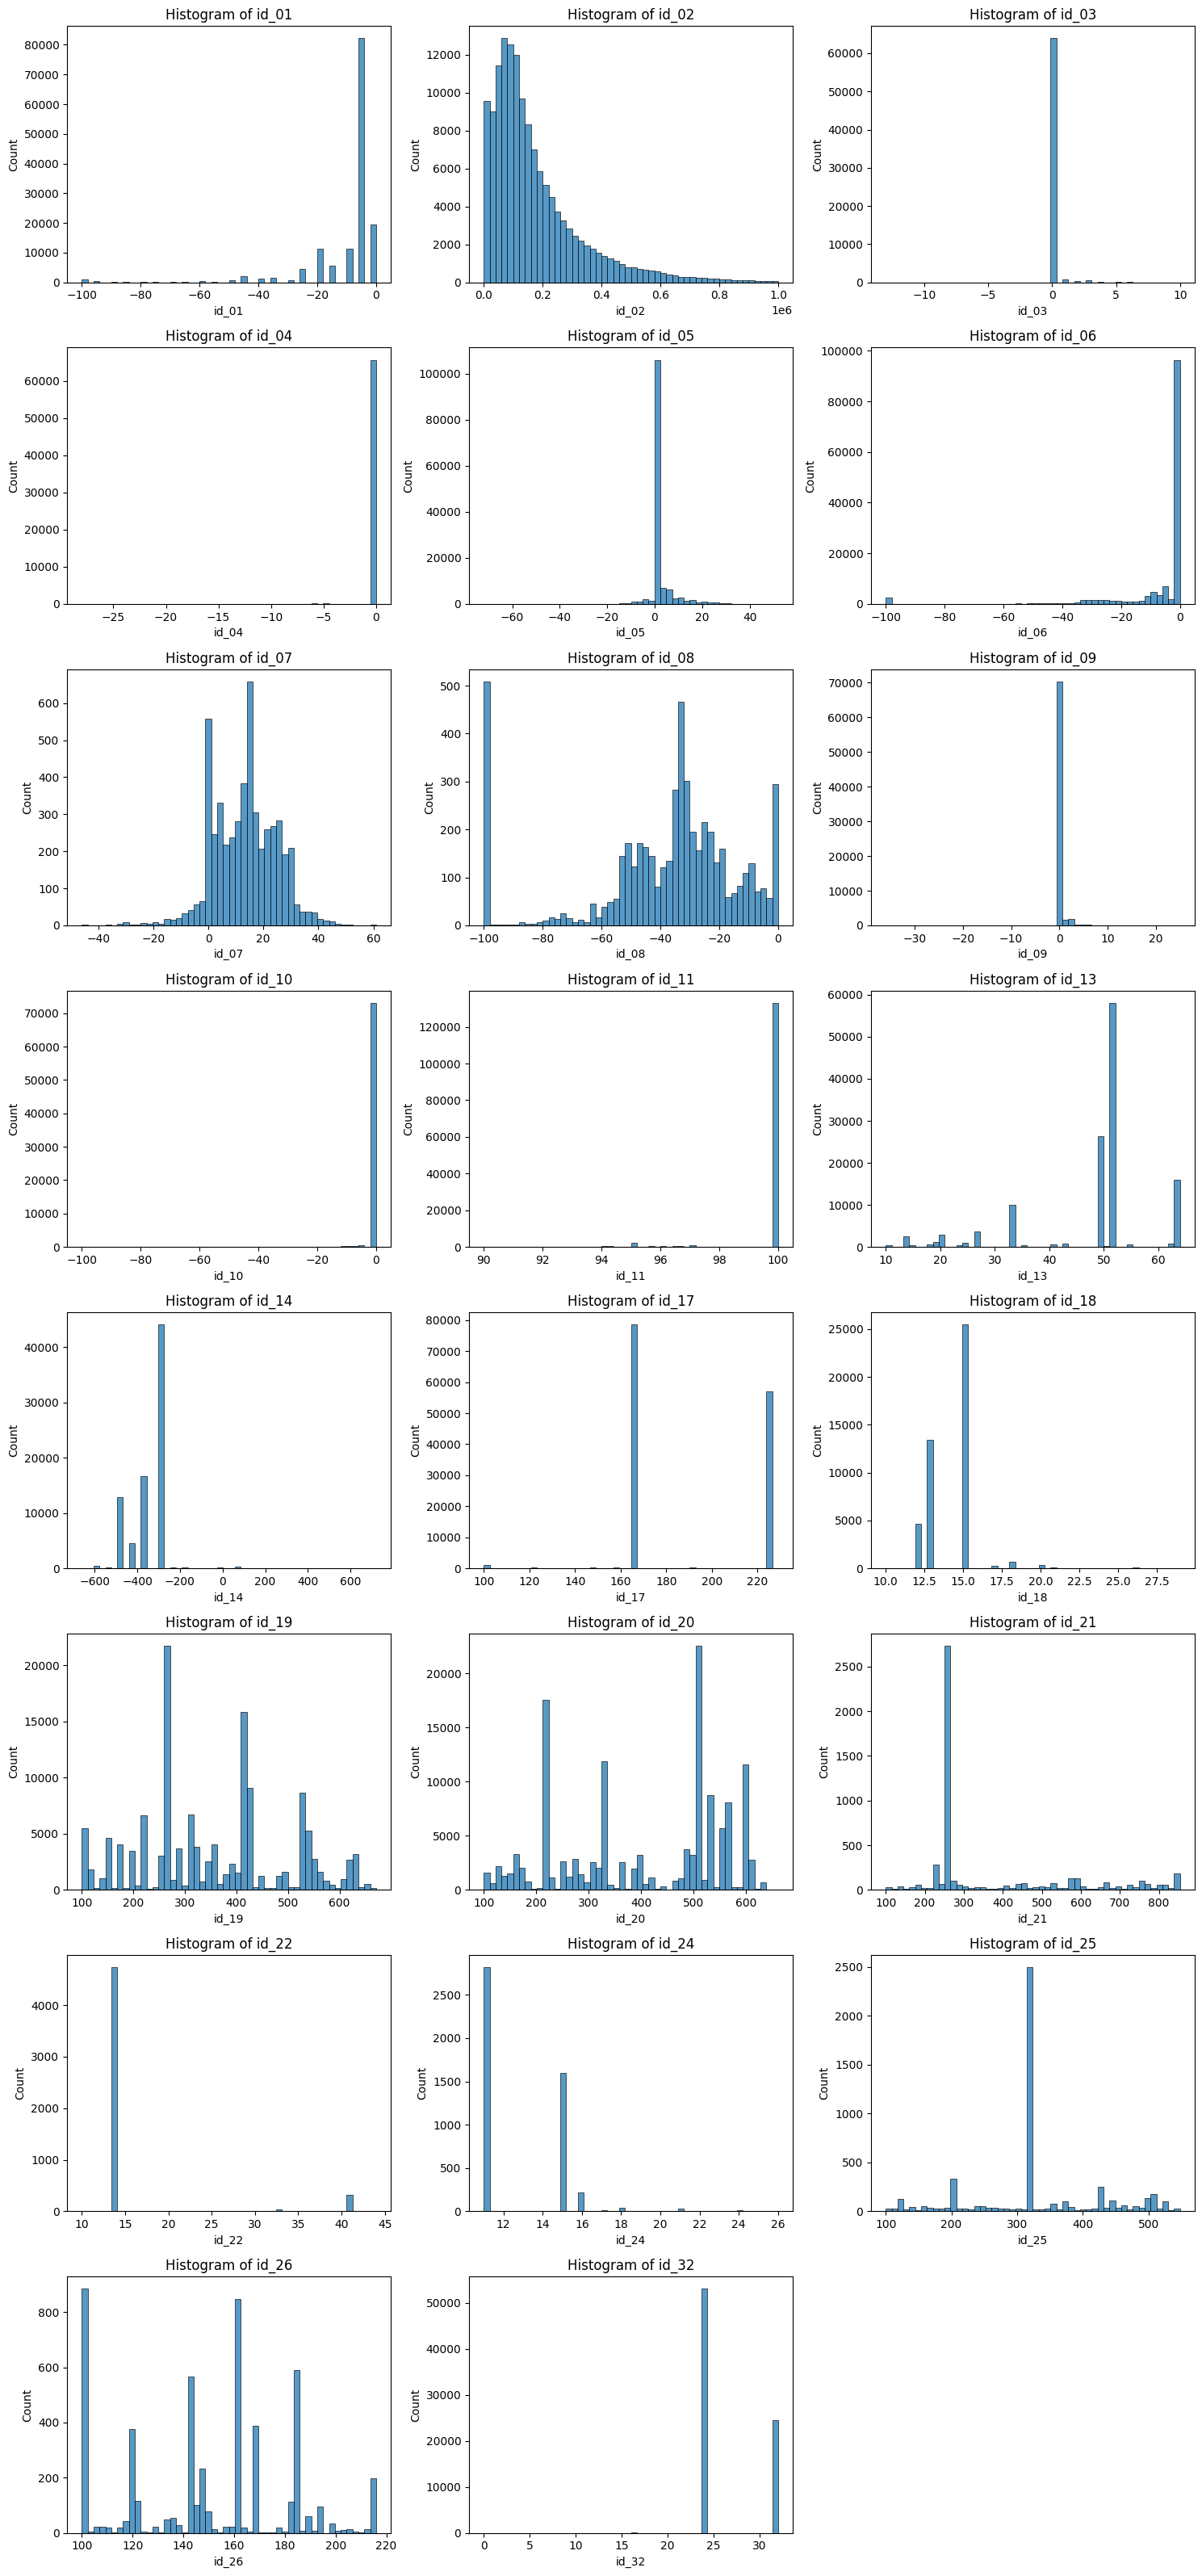

In [60]:
n = len(id_nums_cols)
n_cols = 3
n_rows = (n + n_cols - 1) // n_cols

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))

for i, col in enumerate(id_nums_cols):
    ax = axs[i // n_cols, i % n_cols]
    sns.histplot(df[col].dropna(), bins=50, kde=False, ax=ax)
    ax.set_title(f'Histogram of {col}')

for j in range(i+1, n_rows*n_cols):
    fig.delaxes(axs[j // n_cols, j % n_cols])

plt.tight_layout()
plt.show()

In [61]:
# caculate IV values
iv_values_id = {}
for col in id_cols:
    iv = calculate_iv(df, col, 'isFraud')
    iv_values_id[col] = iv
iv_series_id = pd.Series(iv_values_id).sort_values(ascending=False)


In [62]:
# filter C features with IV > 0.3 and IV < 0.5
iv_series_id = iv_series_id[(iv_series_id > 0.3) & (iv_series_id < 0.5)].index.tolist()
iv_series_id

['id_07', 'id_08', 'id_31', 'id_30', 'id_17']

In [63]:
df[iv_series_id].head()

,id_07,id_08,id_31,id_30,id_17
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,samsung browser 6.2,Android 7.0,166.0


### ID_1

In [64]:
df['id_01'].unique()

array([  nan,    0.,   -5.,  -15.,  -10.,  -20.,  -40.,  -30.,  -25.,
        -55.,  -45.,  -70.,  -90., -100.,  -65.,  -60.,  -75.,  -72.,
        -50.,  -21.,  -35.,  -85.,  -64.,  -80.,  -95.,  -87.,  -58.,
         -7.,  -12.,  -11.,   -9.,  -27.,  -42.,   -6.,  -62.,  -18.,
        -76.,  -23.,  -19.,  -99.,  -13.,  -26.,  -31.,  -17.,  -22.,
        -14.,  -34.,  -54.,  -53.,  -28.,  -88.,  -16.,  -61.,  -46.,
        -94.,  -24.,  -93.,  -44.,  -89.,  -92.,  -37.,  -96.,  -57.,
        -29.,  -33.,  -32.,   -8.,  -52.,  -43.,  -38.,  -86.,  -47.,
        -82.,  -48.,  -63.,  -71.,  -56.,  -51.])

<Axes: xlabel='id_01', ylabel='Count'>

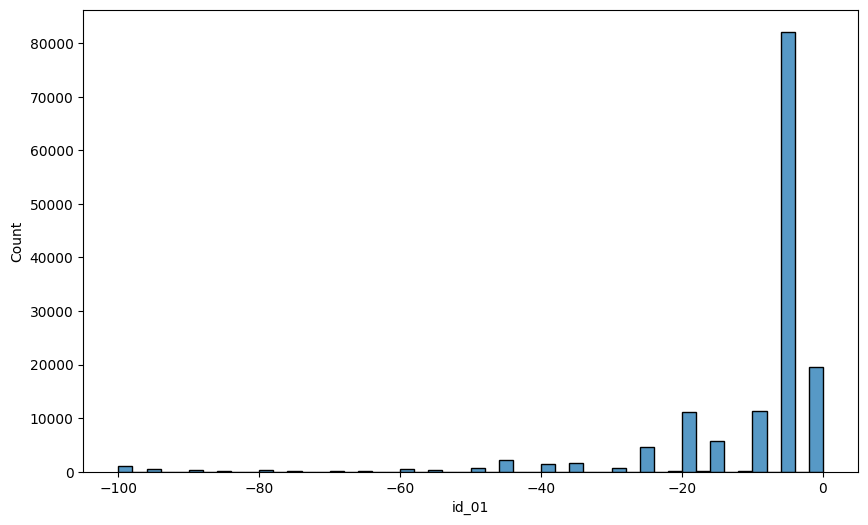

In [65]:
# hist of Id_01
plt.figure(figsize=(10,6))
sns.histplot(df['id_01'], bins=50, kde=False)


- Fill median

In [66]:
df['id_01'].fillna(df['id_01'].median(), inplace=True)


C:\Users\LEGION\AppData\Local\Temp\ipykernel_14232\2465700507.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['id_01'].fillna(df['id_01'].median(), inplace=True)


In [67]:
df['id_01'].isnull().sum()

np.int64(0)

<Axes: xlabel='id_01'>

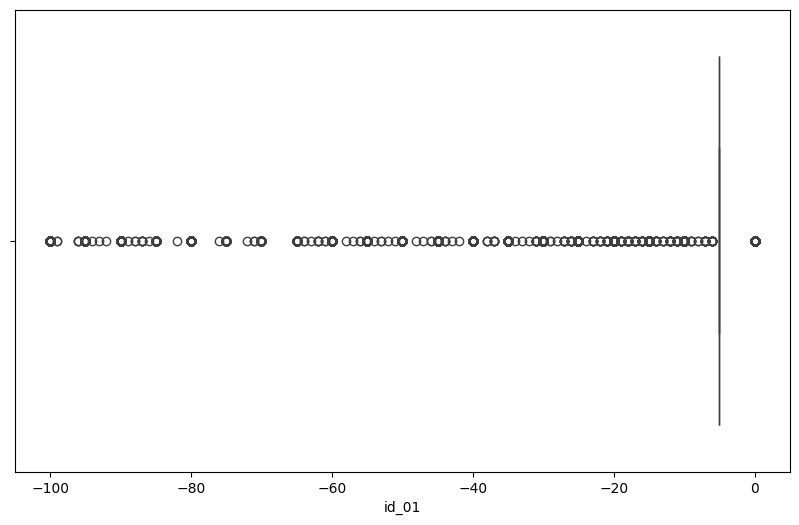

In [68]:
# box plot
plt.figure(figsize=(10,6))
sns.boxplot(x=df['id_01'])

- Using robust scaler to reduce outlier effect

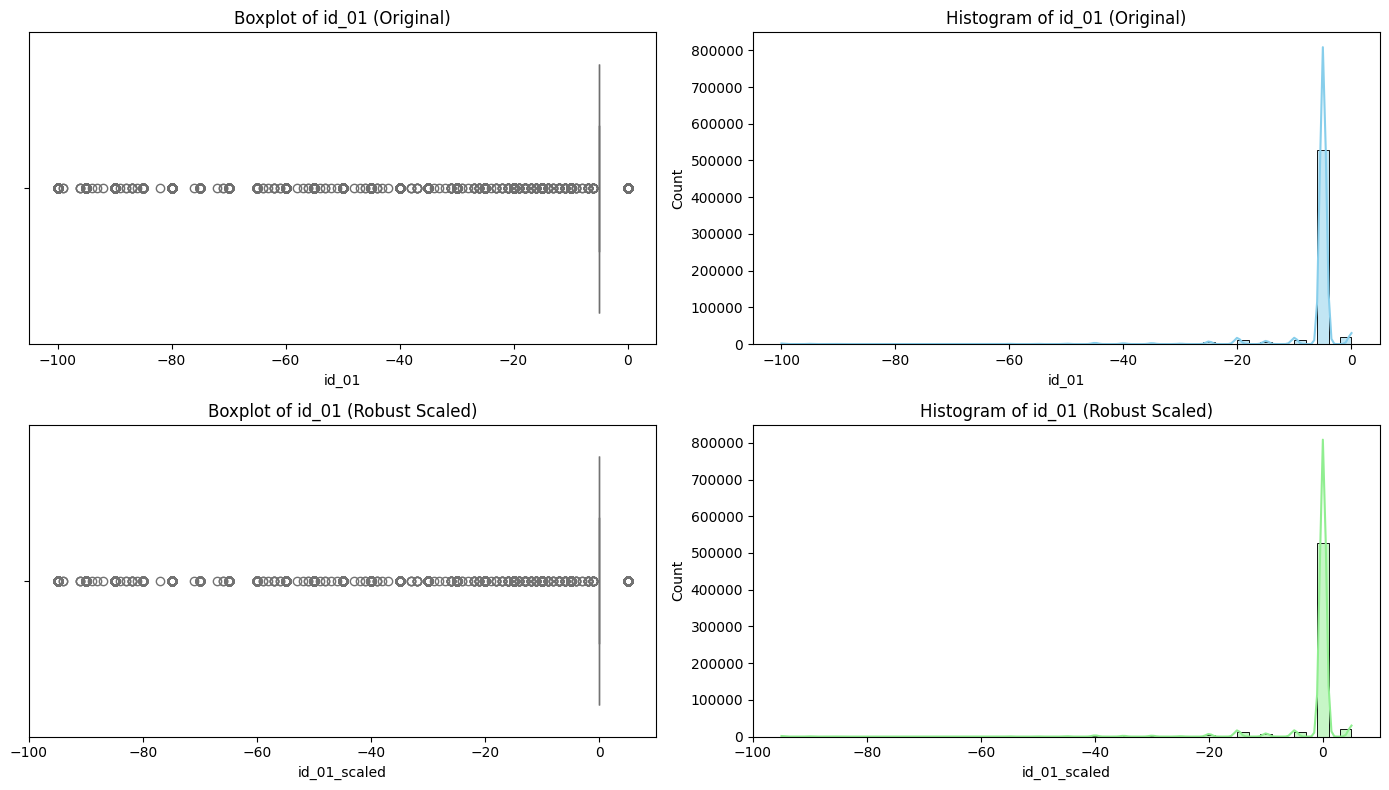

In [69]:

scaler = RobustScaler()
id01_scaled = scaler.fit_transform(df[['id_01']])
df_id01_scaled = pd.DataFrame(id01_scaled, columns=['id_01_scaled'])

fig, axs = plt.subplots(2, 2, figsize=(14, 8))

sns.boxplot(x=df['id_01'], ax=axs[0, 0], color="skyblue")
axs[0, 0].set_title("Boxplot of id_01 (Original)")

sns.boxplot(x=df_id01_scaled['id_01_scaled'], ax=axs[1, 0], color="lightgreen")
axs[1, 0].set_title("Boxplot of id_01 (Robust Scaled)")

sns.histplot(df['id_01'], bins=50, kde=True, ax=axs[0, 1], color="skyblue")
axs[0, 1].set_title("Histogram of id_01 (Original)")

sns.histplot(df_id01_scaled['id_01_scaled'], bins=50, kde=True, ax=axs[1, 1], color="lightgreen")
axs[1, 1].set_title("Histogram of id_01 (Robust Scaled)")

plt.tight_layout()
plt.show()


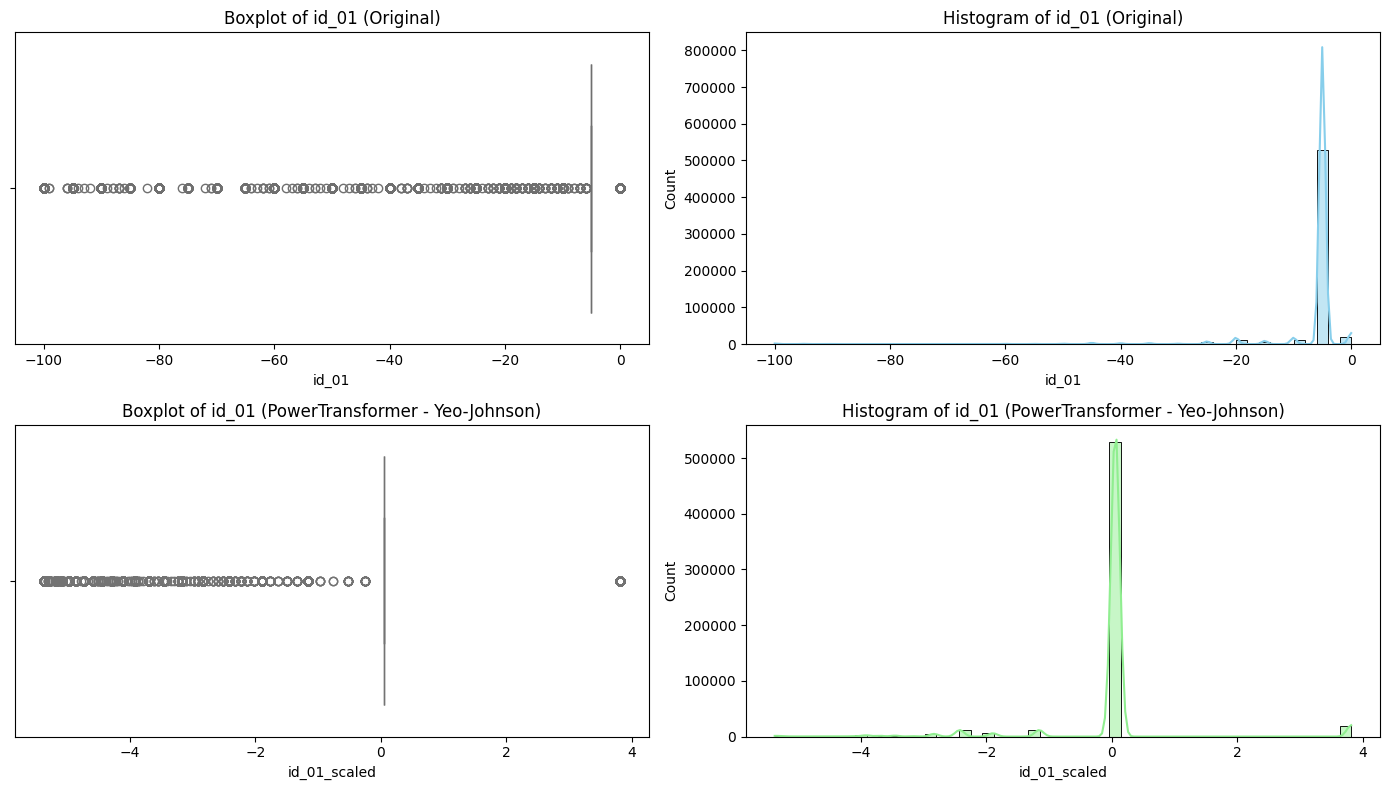

In [70]:
from sklearn.preprocessing import PowerTransformer


scaler = PowerTransformer(method="yeo-johnson")
id01_scaled = scaler.fit_transform(df[['id_01']])
df_id01_scaled = pd.DataFrame(id01_scaled, columns=['id_01_scaled'])

fig, axs = plt.subplots(2, 2, figsize=(14, 8))

sns.boxplot(x=df['id_01'], ax=axs[0, 0], color="skyblue")
axs[0, 0].set_title("Boxplot of id_01 (Original)")

sns.boxplot(x=df_id01_scaled['id_01_scaled'], ax=axs[1, 0], color="lightgreen")
axs[1, 0].set_title("Boxplot of id_01 (PowerTransformer - Yeo-Johnson)")

sns.histplot(df['id_01'], bins=50, kde=True, ax=axs[0, 1], color="skyblue")
axs[0, 1].set_title("Histogram of id_01 (Original)")

sns.histplot(df_id01_scaled['id_01_scaled'], bins=50, kde=True, ax=axs[1, 1], color="lightgreen")
axs[1, 1].set_title("Histogram of id_01 (PowerTransformer - Yeo-Johnson)")

plt.tight_layout()
plt.show()


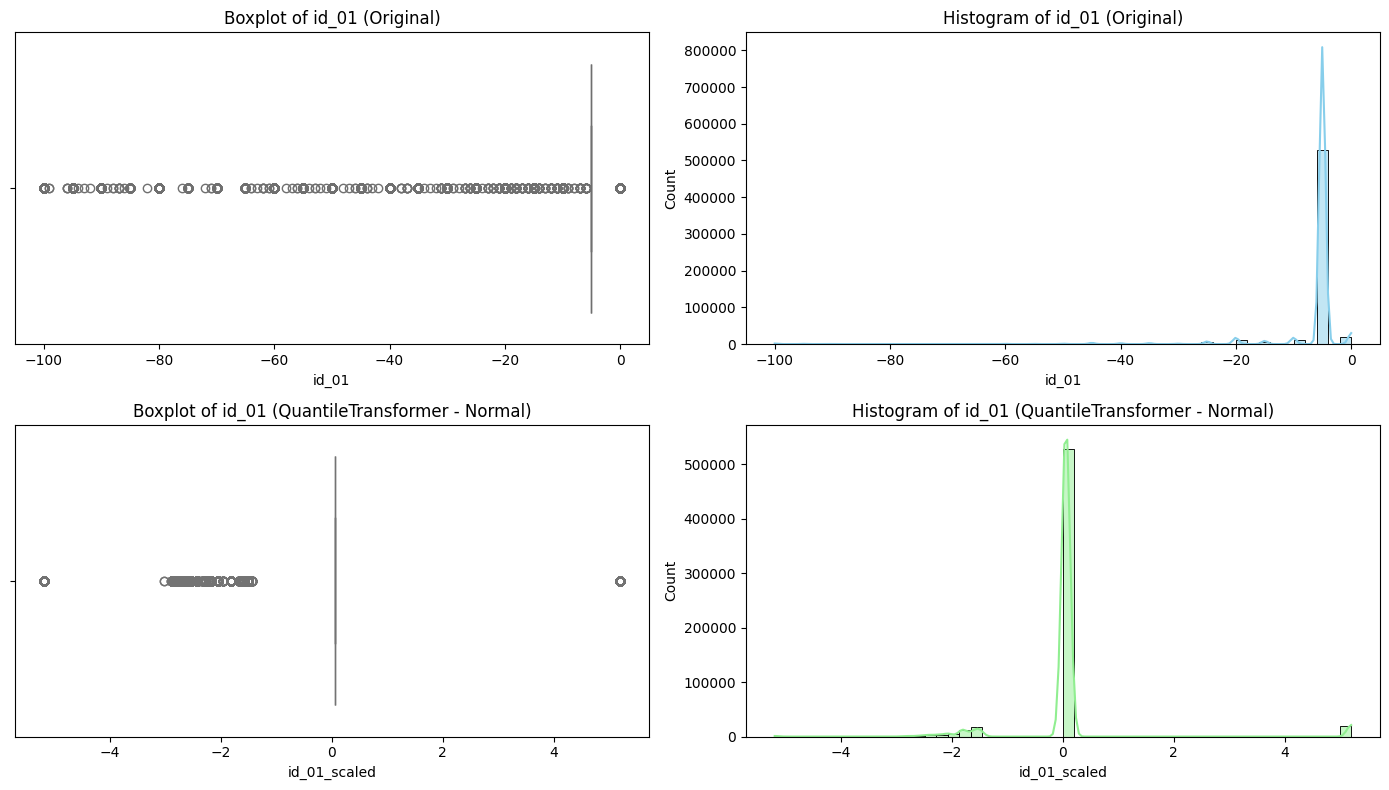

In [71]:
from sklearn.preprocessing import QuantileTransformer


scaler = QuantileTransformer(output_distribution="normal", random_state=42)
id01_scaled = scaler.fit_transform(df[['id_01']])
df_id01_scaled = pd.DataFrame(id01_scaled, columns=['id_01_scaled'])

fig, axs = plt.subplots(2, 2, figsize=(14, 8))

sns.boxplot(x=df['id_01'], ax=axs[0, 0], color="skyblue")
axs[0, 0].set_title("Boxplot of id_01 (Original)")

sns.boxplot(x=df_id01_scaled['id_01_scaled'], ax=axs[1, 0], color="lightgreen")
axs[1, 0].set_title("Boxplot of id_01 (QuantileTransformer - Normal)")

sns.histplot(df['id_01'], bins=50, kde=True, ax=axs[0, 1], color="skyblue")
axs[0, 1].set_title("Histogram of id_01 (Original)")

sns.histplot(df_id01_scaled['id_01_scaled'], bins=50, kde=True, ax=axs[1, 1], color="lightgreen")
axs[1, 1].set_title("Histogram of id_01 (QuantileTransformer - Normal)")

plt.tight_layout()
plt.show()


### id_31

In [72]:
df['id_31'].unique()

array([nan, 'samsung browser 6.2', 'mobile safari 11.0', 'chrome 62.0',
       'chrome 62.0 for android', 'edge 15.0', 'mobile safari generic',
       'chrome 49.0', 'chrome 61.0', 'edge 16.0', 'safari generic',
       'edge 14.0', 'chrome 56.0 for android', 'firefox 57.0',
       'chrome 54.0 for android', 'mobile safari uiwebview', 'chrome',
       'chrome 62.0 for ios', 'firefox', 'chrome 60.0 for android',
       'mobile safari 10.0', 'chrome 61.0 for android',
       'ie 11.0 for desktop', 'ie 11.0 for tablet', 'mobile safari 9.0',
       'chrome generic', 'other', 'chrome 59.0 for android',
       'firefox 56.0', 'android webview 4.0', 'chrome 55.0', 'opera 49.0',
       'ie', 'chrome 55.0 for android', 'firefox 52.0',
       'chrome 57.0 for android', 'chrome 56.0',
       'chrome 46.0 for android', 'chrome 58.0', 'firefox 48.0',
       'chrome 59.0', 'samsung browser 4.0', 'edge 13.0',
       'chrome 53.0 for android', 'chrome 58.0 for android',
       'chrome 60.0', 'mobile sa

In [73]:
df['id_31'].isnull().sum()

np.int64(450258)

In [74]:
df['id_31'].fillna('unknown', inplace=True)

C:\Users\LEGION\AppData\Local\Temp\ipykernel_14232\1428688064.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['id_31'].fillna('unknown', inplace=True)


### ID_35

In [75]:
df['id_35'].unique()

array([nan, 'T', 'F'], dtype=object)

In [76]:
df['id_35'].isnull().sum()

np.int64(449555)

In [77]:
df['id_35'] = df['id_35'].fillna(df['id_35'].mode()[0])

### ID_22

In [78]:
df['id_22'].unique()

array([nan, 14., 41., 21., 33., 35., 19., 20., 31., 12., 36., 23., 28.,
       40., 24., 39., 22., 43., 26., 44., 10., 17., 38., 37., 18., 42.])

In [79]:
df['id_22'].isnull().sum(0)

np.int64(585371)

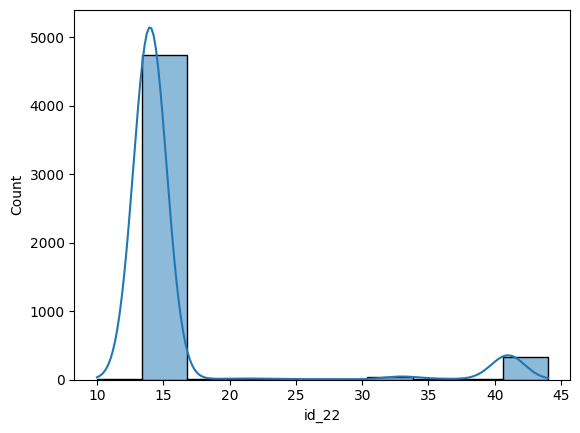

In [80]:
sns.histplot(data=df, x='id_22', bins = 10 , kde=True)
plt.show()


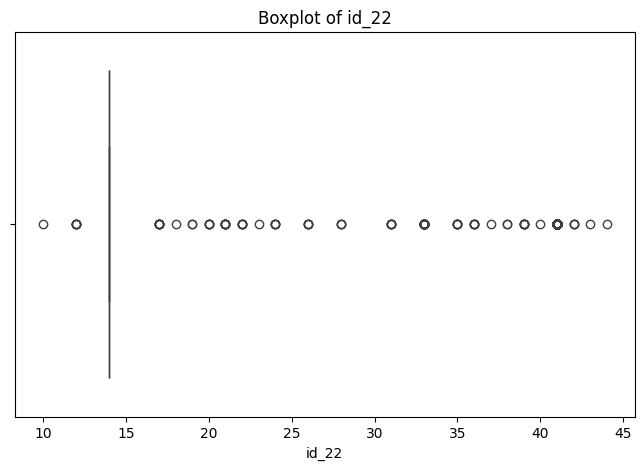

In [81]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=df['id_22'])
plt.title("Boxplot of id_22")
plt.show()


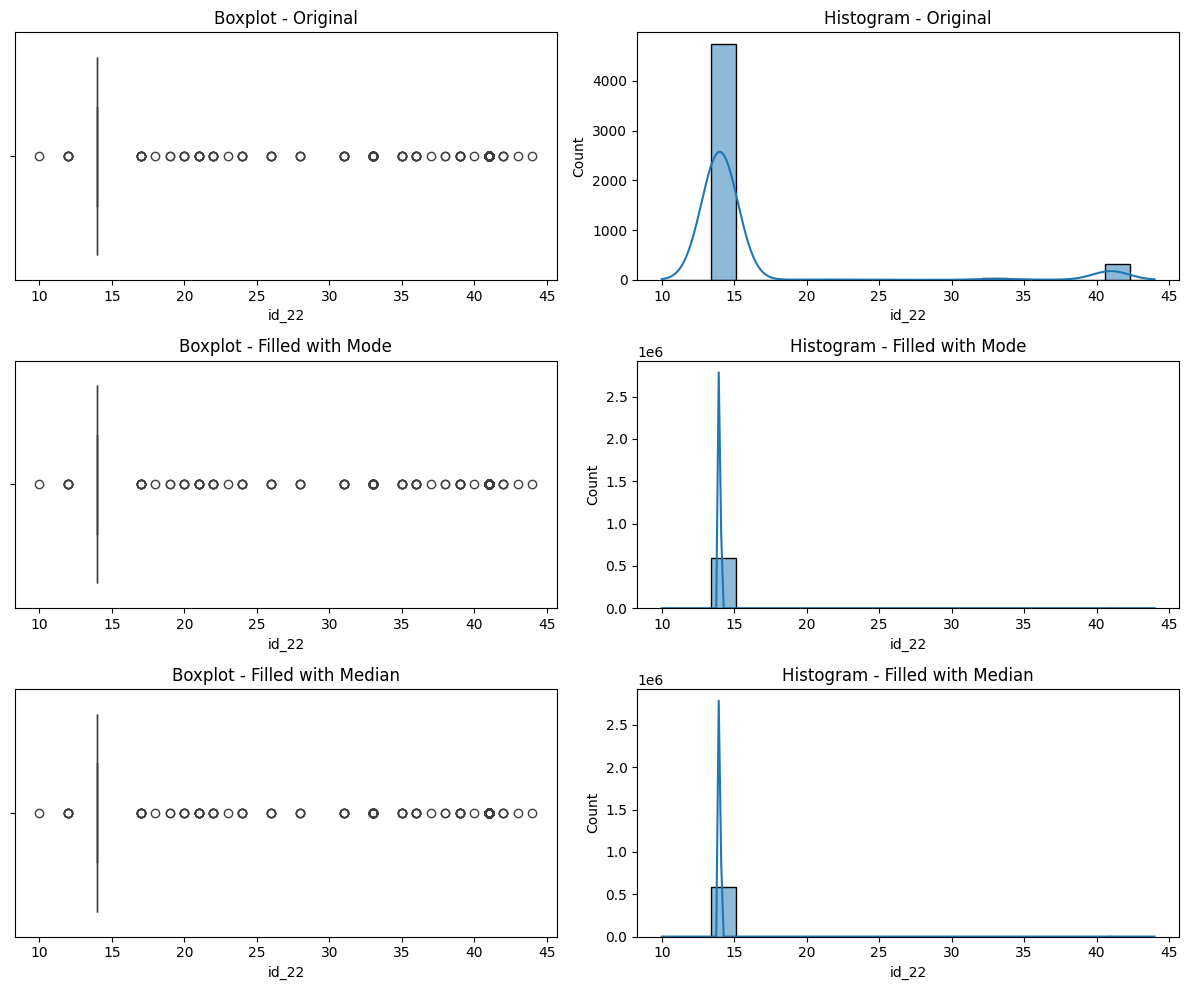

In [82]:
id22_original = df['id_22']
id22_mode = df['id_22'].fillna(df['id_22'].mode()[0])
id22_median = df['id_22'].fillna(df['id_22'].median())

fig, axes = plt.subplots(3, 2, figsize=(12, 10))

# Original - Boxplot
sns.boxplot(x=id22_original, ax=axes[0, 0])
axes[0, 0].set_title("Boxplot - Original")

# Original - Histogram
sns.histplot(id22_original, bins=20, kde=True, ax=axes[0, 1])
axes[0, 1].set_title("Histogram - Original")

# Mode - Boxplot
sns.boxplot(x=id22_mode, ax=axes[1, 0])
axes[1, 0].set_title("Boxplot - Filled with Mode")

# Mode - Histogram
sns.histplot(id22_mode, bins=20, kde=True, ax=axes[1, 1])
axes[1, 1].set_title("Histogram - Filled with Mode")

# Median - Boxplot
sns.boxplot(x=id22_median, ax=axes[2, 0])
axes[2, 0].set_title("Boxplot - Filled with Median")

# Median - Histogram
sns.histplot(id22_median, bins=20, kde=True, ax=axes[2, 1])
axes[2, 1].set_title("Histogram - Filled with Median")

plt.tight_layout()
plt.show()


# EDA
- Visualize data to explore information

In [85]:
df.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D10,D11,D12,D13,D14,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_13,id_14,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,238269.000000,37627.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: category(1), float64(393), int64(3), object(37)
memory usage: 1.9+ GB


# Mining process

# Modeling